# 0.0 DATA IMPORTS

In [ ]:
!pip install inflection
!pip install boruta

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import random
import inflection
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image
from scipy                  import stats as stats
from boruta                 import BorutaPy

from sklearn.ensemble       import RandomForestRegressor
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso, Ridge, ElasticNet


## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 40
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

def cramer_v(x, y):
    # Contingency Table (all combinations between categorical variables)
    cm = pd.crosstab(x, y)
    
    #chi2
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r, k = cm.shape
    phi = chi2/n
    phibiascorrect = max(0, phi - (k-1)*(r-1)/(n-1))
    k_denominator = k - (k-1)**2 / (n-1)
    r_denominator = r - (r-1)**2 / (n-1) 
    denominator = min(k_denominator-1, r_denominator-1)
    return np.sqrt(phibiascorrect / denominator)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])
    
def cross_validation(x_training, model_name, model, kfold, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in range(1, kfold+1):
        if verbose:
          print('\nKfold Number: {}'.format(k))
        # creating date limits for validation data. 
        validation_start_date = x_training['date'].min() + datetime.timedelta(days = k*6*7) 
        validation_end_date = x_training['date'].min() + datetime.timedelta(days = (k+1)*6*7)

        # filtering dataset for k-folds
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] < validation_end_date)]

        # splitting training and validation datasets
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        xvalid = validation.drop(['date','sales'], axis = 1)
        yvalid = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)
        # prediction
        yhat = m.predict(xvalid)
        # performance
        result = ml_error(model_name, np.expm1(yvalid), np.expm1(yhat))
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])
       
    return pd.DataFrame({'Model Name': model_name, 
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [117]:
# upload dataset on google colab
from google.colab import files
uploaded = files.upload()

Saving unemployment_germany.csv to unemployment_germany.csv
Saving interest_germany.csv to interest_germany.csv
Saving germany_gdp.csv to germany_gdp.csv
Saving cpi_germany.csv to cpi_germany.csv


In [5]:
# load dataset
# df_store_raw = pd.read_csv('data/store.csv', low_memory=False)
# df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)
df_sales_raw = pd.read_csv('train.csv', low_memory=False)

In [ ]:
# check dataset shape and column names
print(df_store_raw.shape) # 1115 stores, 10 columns
print(df_sales_raw.shape) #1017209 sales, 9 columns
print(df_sales_raw.columns.to_list()) #1017209 sales, 9 columns
print(df_store_raw.columns.to_list()) # 1115 stores, 10 columns

(1115, 10)
(1017209, 9)
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


In [83]:
# merge sales and store datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [84]:
# copy previous dataset
df1 = df_raw.copy()

In [85]:
# store columns of dataset on new variable
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# rename all columns to snakecase type
new_cols = list(map(lambda x: inflection.underscore(x), old_cols))
new_cols
df1.columns = new_cols
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Data Dimensions

In [86]:
# check dimensions of dataset
print(f'# rows: {df1.shape[0]} | # columns: {df1.shape[1]}')

# rows: 1017209 | # columns: 18


## 1.3. Data Types

In [87]:
# transform data variable to date type
df1['date'] = pd.to_datetime(df1['date'])
# check data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking & Filling out NA Values

In [88]:
# check missing values
missing_percentage(df1)

,Total,Percent
promo_interval,508031,49.94
promo2_since_week,508031,49.94
promo2_since_year,508031,49.94
competition_open_since_year,323348,31.79
competition_open_since_month,323348,31.79
competition_distance,2642,0.26


### 1.4.1. competition_distance

In [90]:
# check if null values are consistent with variable 'competition_open_since_year'
df1[df1['competition_distance'].isna()]['competition_open_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [70]:
# get descriptive statistics 
df1['competition_distance'].describe()

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: competition_distance, dtype: float64

In [91]:
# For nan values, a number higher than the maximum value (200000) was imputed to NaN values since it represents non-existence of competition
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

### 1.4.2. competition_open_since_month & competition_open_since_year

In [72]:
# check if null values are consistent with variable 'competition_open_since_month'
df1[df1['competition_open_since_year'].isna()]['competition_open_since_month'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [73]:
# check if null values are consistent with variable 'competition_open_since_year'
df1[df1['competition_open_since_month'].isna()]['competition_open_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [74]:
# get descriptive statistics 
df1['competition_open_since_month'].describe()

count    693861.000000
mean          7.222866
std           3.211832
min           1.000000
25%           4.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: competition_open_since_month, dtype: float64

In [75]:
# get descriptive statistics 
df1['competition_open_since_year'].describe()

count    693861.000000
mean       2008.690228
std           5.992644
min        1900.000000
25%        2006.000000
50%        2010.000000
75%        2013.000000
max        2015.000000
Name: competition_open_since_year, dtype: float64

In [92]:
# Use information on column 'date' to fill out NaN values
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                               if math.isnan( x['competition_open_since_year'] ) 
                                               else x['competition_open_since_year'], axis=1 )


### 1.4.3. promo2_since_year & promo2_since_week

In [77]:
# check if null values are consistent with variable 'promo2_since_week'
df1[df1['promo2_since_year'].isna()]['promo2_since_week'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [78]:
# check if null values are consistent with variable 'promo2_since_year'
df1[df1['promo2_since_week'].isna()]['promo2_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [79]:
# get descriptive statistics 
df1['promo2_since_year'].describe()

count    509178.000000
mean       2011.752774
std           1.662870
min        2009.000000
25%        2011.000000
50%        2012.000000
75%        2013.000000
max        2015.000000
Name: promo2_since_year, dtype: float64

In [80]:
# get descriptive statistics 
df1['promo2_since_week'].describe() # a year has approx 52 weeks.

count    509178.000000
mean         23.269093
std          14.095973
min           1.000000
25%          13.000000
50%          22.000000
75%          37.000000
max          50.000000
Name: promo2_since_week, dtype: float64

In [93]:
# Use information on column 'date' to fill out NaN values
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis = 1)

### 1.4.4. promo_interval

In [95]:
# check if null values are consistent with variable 'promo2'
df1[df1['promo_interval'].isna()]['promo2'].value_counts(dropna = True) # if zero is the unique value, NaN values on 'promo_interval' are consistent with 'promo2'

0    508031
Name: promo2, dtype: int64

In [96]:
# verify variable nature
df1['promo_interval'].value_counts(dropna = False)

NaN                 508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: promo_interval, dtype: int64

In [98]:
# perform imputation by mapping month names to numbers

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May', 
             6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['promo_interval'].fillna(0, inplace = True)
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul


In [99]:
# Create new variable 'is_promo'. If store is opened and running consecutive promo on that period (promo_interval), we assign 1 (and zero otherwise) 
# (we will drop 'promo_interval' later)

df1['is_promo2'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 
                            else 1 if x['month_map'] in x['promo_interval'].split(',') 
                            else 0, axis = 1)

In [101]:
missing_percentage(df1)

,Total,Percent


## 1.5. Change Dtypes

In [100]:
# change dtypes to their appropriate type.
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int) 

In [102]:
# checking dtypes
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

## 1.7. Descriptive Statistics

In [103]:
# separate numerical and categorical features
num_feat = df1.select_dtypes( include = ['int64','float64'])
cat_feat = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])

In [107]:
num_feat.sample(1)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2
772785,876,4,7953,1061,1,0,1,21790.0,4,2005,1,18,2015,1


In [106]:
cat_feat.sample(1)

,state_holiday,store_type,assortment,promo_interval,month_map
200680,0,a,c,"Mar,Jun,Sept,Dec",Fev


### 1.7.1. Numerical Features

In [108]:
#### Central Tendency 
# 1st moment (mean)
ct_mean = pd.DataFrame(num_feat.apply( np.mean )).T
# median
ct_median = pd.DataFrame(num_feat.apply( np.median )).T

#### Dispersion
# 2nd moment (variance)
d_var = pd.DataFrame(num_feat.apply( np.var)).T
# std
d_std = pd.DataFrame(num_feat.apply( np.std)).T
# min
d_min = pd.DataFrame(num_feat.apply(min)).T
# max
d_max = pd.DataFrame(num_feat.apply(max)).T
# range
d_range = pd.DataFrame(num_feat.apply(lambda x: x.max() - x.min())).T
# 3rd moment (Skew)
d_sk = pd.DataFrame(num_feat.apply(lambda x: x.skew())).T
# 4th moment (Kurtosis)
d_kurt = pd.DataFrame(num_feat.apply(lambda x: x.kurtosis())).T
# Q1 quantile
d_q1 = pd.DataFrame(num_feat.apply(lambda x: np.quantile(x, .25))).T
# Q3 quantile
d_q3 = pd.DataFrame(num_feat.apply(lambda x: np.quantile(x, .75))).T


In [109]:
# concatenate
m = pd.concat([d_min, d_max, d_range, ct_mean, d_q1, ct_median, d_q3, d_std, d_sk, d_kurt]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','25%', '50%','75%','std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,25%,50%,75%,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,280.0,558.0,838.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,2.0,4.0,6.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,3727.0,5744.0,7856.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,405.0,609.0,837.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.0,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,710.0,2330.0,6910.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,4.0,7.0,10.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2008.0,2012.0,2014.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Features

In [111]:
# check unique values of each feature
cat_feat.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

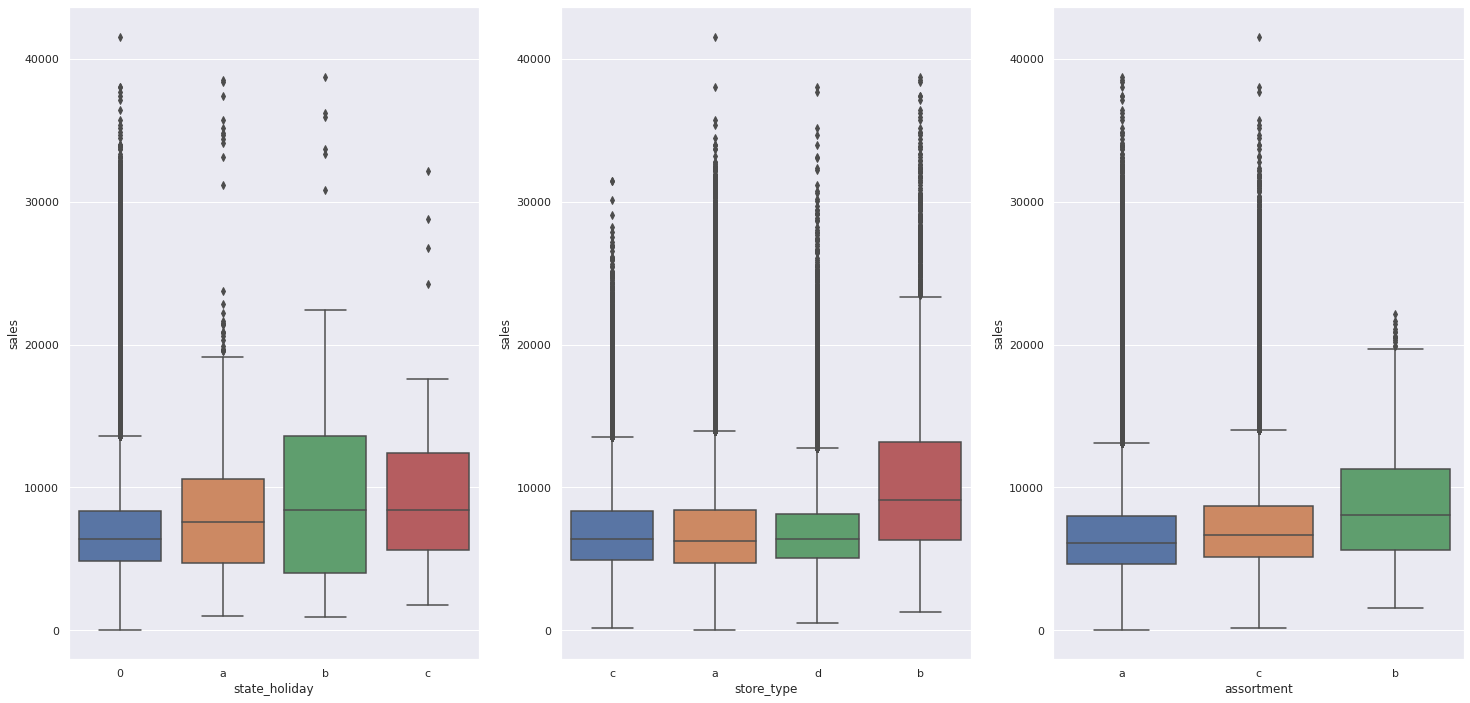

In [110]:
# plotting boxplots (categorical variables against target variable)
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] != 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);


# 2.0. STEP 02 - FEATURE ENGINEERING

In [112]:
# copy previous dataset
df2 = df1.copy()

## 2.1. Hypothesis MindMap

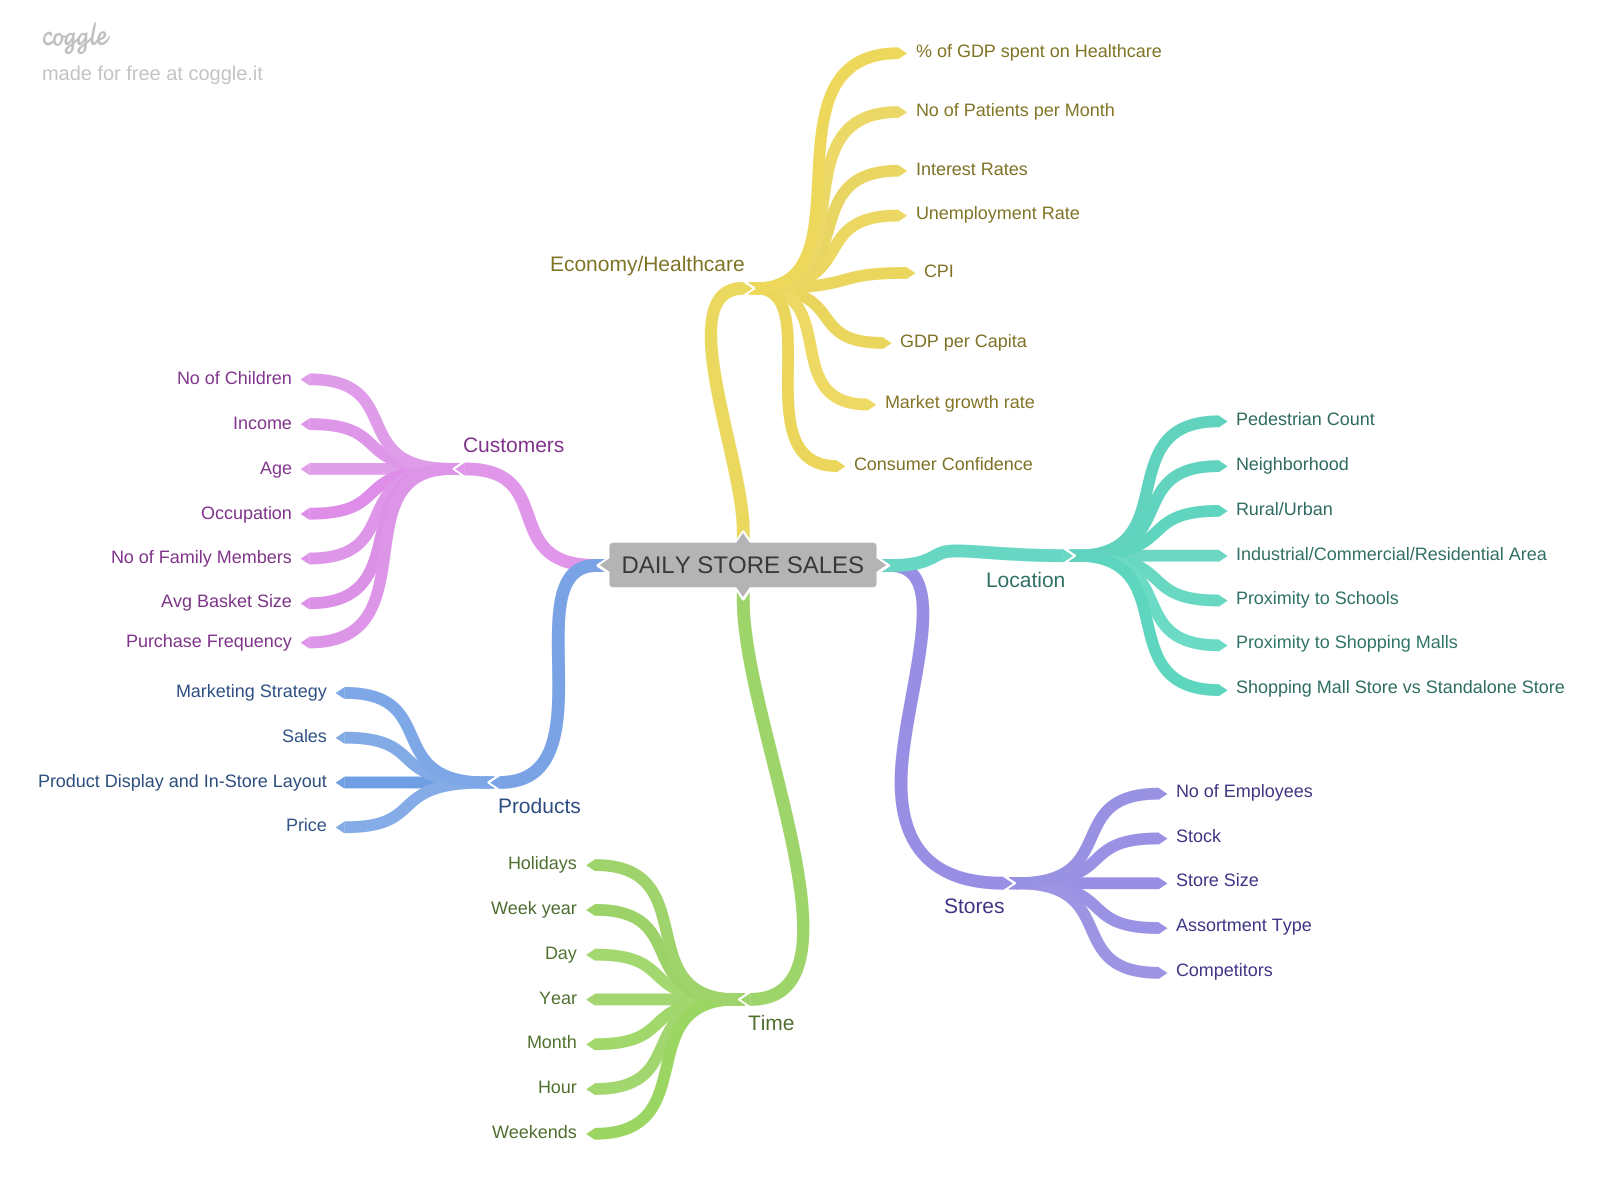

In [ ]:
Image('img/DAILY_STORE_SALES.png' )

## 2.2. Hypothesis Creation

### 2.2.1. Stores

**1.**  Stores with more employees sell more  
**2.**  Stores with bigger available stock sell more  
**3.**  Bigger stores sell more  
**4.**  Stores with extended assortment type sell more  
**5.**  Stores near competitors sell less  
**6.**  Stores with newly opened competitors sell less than stores with old competitors  


### 2.2.2. Time

**1.**  Stores sell more on weekdays than weekends/holidays (sales rate)  
**2.**  Stores sell more during the 2nd semester  
**3.**  Stores sell more during summer/winter breaks (schools)    
**4.**  Stores sell less during school holidays  
**5.**  Stores sell more on Christmas than other holidays      
**6.**  Stores are selling more along the years  
**7.**  Stores sell more after day 10 of each month  
**8.**  Stores sell more along the years  


### 2.2.3. Products

**1.**  Stores with higher marketing investments sell more  
**2.**  Stores with products in promotion displayed at the entrance sell more  
**3.**  Stores with cheaper products sell more    
**4.**  Stores with aggresive price strategies sell more  
**5.**  Stores frequently doing standalone promo sales sell more  
**6.**  Stores doing consecutive promo sales in the beginning of the year sell more  
**7.**  Stores participating in consecutive promo for a longer time sell more  
**8.**  Stores with more consecutive promo sale days sell more  

### 2.2.4. Customers 
note: number of customers is not possible to be used on the model unless a customer prediction project is done.

**1.**  Stores with more customers who have children sell more  
**2.**  Stores with more customers who have higher income sell more  
**3.**  Stores with more elderly customers sell more   
**4.**  Stores with more customers who have higher # of family members sell more  
**5.**  Stores with more loyal customers sell more  


### 2.2.5. Location
note: Location of each store is not given. Hypothesis are displayed below just for the purpose of completeness.

**1.**  Stores with higher pedestrian count (front street) sell more  
**2.**  Stores located in an expensive neighborhood sell more  
**3.**  Stores located in urban areas sell more    
**4.**  Stores located in residential areas sell more   
**5.**  Stores near schools sell more  
**6.**  Stores near shopping malls sell more  
**7.**  Stores located inside malls sell more than standalone stores  

### 2.2.6. External Factors (Economy/Healthcare/Weather)
Some caveats on data acquisition are explained below:
*   Economy: usually macroeconomic data would not be relevant to the model since its impact tend to affect all stores as a whole. However, some macroeconomic data could be relevant if divided by location or month/week. Since such kind of data is difficult to find, some hypotheses are displayed below just for the purpose of completeness.   

*   Healthcare: related data was either unavailable on public datasets or not possible to be utilized.
*   Weather: although Rossmann stores are mainly located in Germany,  their location is not present on the dataset. Therefore, the usage of weather as a predictor for this model would be a big assumption to take.


**1.**  Stores within areas with low unemployment rate sell more  
**2.**  Stores within areas with high number of patients sell more  
**3.**  Stores within areas with high Gross Domestic Product Per Capita (GDPpc) sell more    
**4.**  Stores sales increase when GDPpc increases (month)  
**5.**  Stores sales increase when interest rates decrease (month)  
**6.**  Stores sales increase when Consumer Price Index (CPI) rate increases (month)  
**7.**  Stores sales increase when the number of patients hospitalized (per month) increase  
**8.**  Stores sales increase when the air quality gets worse (AQI)  
**9.**  Store sales increase when the weather is above 28ºC or below 18ºC

## 2.3. Viable Hypothesis List

**1.**  Stores with extended assortment type sell more  
**2.**  Stores near competitors sell less  
**3.**  Stores with newly opened competitors sell less than stores with old competitors  
**4.**  Stores sell more on weekdays than weekends/holidays (sales rate)  
**5.**  Stores sell more during the 2nd semester  
**6.**  Stores sell more during summer/winter breaks (schools)    
**7.**  Stores sell less during school holidays  
**8.**  Stores opened during Christmas sell more    
**9.**  Stores are selling more along the years  
**10.**  Stores sell more after day 10 of each month  
**11.**  Stores frequently doing standalone promo sales sell more   
**12.**  Stores doing consecutive promo sales in the beginning of the year sell more  
**13.**  Stores participating in consecutive promo for a longer time sell more  
**14.**  Stores with more consecutive promo sale days sell more   
**15.**  Stores sales increase when GDPpc increases (month)   
**16.**  Stores sales increase when interest rates decrease (month)  
**17.**  Stores sales increase when Consumer Price Index (CPI) rate increases (month)  



## 2.4. Feature Engineering

In [113]:
# date
df2['date'] = pd.to_datetime(df2['date'])

# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                  month=x['competition_open_since_month'],
                                                                  day=1 ), axis=1 )

# competition_since_month
df2['competition_since_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo2_since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply( lambda x: 
                                              datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# promo2_time_week
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since']) / 7).apply(lambda x: x.days).astype(int)

# promo2_time_month
df2['promo2_time_month'] = ((df2['date'] - df2['promo2_since']) / 30).apply(lambda x: x.days).astype(int)

# day, month, year
df2['day'] = df2['date'].dt.day
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# is_weekday
df2['is_weekday'] = df2.apply(lambda x: 1 if x['date'].weekday() in [0,1,2,3,4] 
                              else 1 if x['state_holiday'] == 0
                              else 0, axis = 1)


In [114]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else 'extra' if x == 'b'
                                            else 'extended')
# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                  else 'easter' if x == 'b'
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')

In [118]:
# GDPpc variable
# https://stats.oecd.org/index.aspx?queryid=66948#
# gdp = pd.read_csv('data/germany_gdp.csv', low_memory = False)
gdp = pd.read_csv('germany_gdp.csv', low_memory = False)
gdp = gdp.loc[(gdp['Country'] == 'Germany') & (gdp['MEASURE'] == 'HCPCARSA'), :]
gdp.columns.to_list()
gdp['year_quarter'] = gdp['TIME'].apply(lambda x: x.strip())
gdp = gdp.drop(['LOCATION', 'TIME','Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure', 'FREQUENCY', 'Frequency', 'Period', 
          'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags'], axis = 1)
df2['quarter'] = 0
df2.loc[df2['month'] == 1, 'quarter'] = 'Q1'
df2.loc[df2['month'] == 2,'quarter'] = 'Q1'
df2.loc[df2['month'] == 3,'quarter'] = 'Q1'
df2.loc[df2['month'] == 4,'quarter'] = 'Q2'
df2.loc[df2['month'] == 5,'quarter'] = 'Q2'
df2.loc[df2['month'] == 6,'quarter'] = 'Q2'
df2.loc[df2['month'] == 7,'quarter'] = 'Q3'
df2.loc[df2['month'] == 8,'quarter'] = 'Q3'
df2.loc[df2['month'] == 9,'quarter'] = 'Q3'
df2.loc[df2['month'] == 10,'quarter'] = 'Q4'
df2.loc[df2['month'] == 11,'quarter'] = 'Q4'
df2.loc[df2['month'] == 12, 'quarter'] = 'Q4'
df2['year_quarter'] = df2['year'].astype(str) + '-' + df2['quarter'].astype(str)
df2 = pd.merge(df2, gdp, how = 'left', on = 'year_quarter')
df2['gdp'] = df2['Value']
df2 = df2.drop(['quarter','Value'], axis = 1)

In [119]:
# CPI index (Ref 2015 = 100)
# cpi = pd.read_csv('data/cpi_germany.csv', low_memory = False)
cpi = pd.read_csv('cpi_germany.csv', low_memory = False)
# cpi = cpi.loc[(cpi['Country'] == 'Germany') & (cpi['Measure'] == 'Index') & (cpi['Subject'] == 'CPI: 01-12 - All items'), :]
# cpi[['year','month']] = cpi['TIME'].str.split('-',expand = True)
# cpi['year'] = cpi['year'].astype(float).astype(int)
# cpi = cpi[cpi['year'] < 2016]

# cpi.loc[cpi['month'] == '01', 'month'] = '1'
# cpi.loc[cpi['month'] == '02','month'] = '2'
# cpi.loc[cpi['month'] == '03','month'] = '3'
# cpi.loc[cpi['month'] == '04','month'] = '4'
# cpi.loc[cpi['month'] == '05','month'] = '5'
# cpi.loc[cpi['month'] == '06','month'] = '6'
# cpi.loc[cpi['month'] == '07','month'] = '7'
# cpi.loc[cpi['month'] == '08','month'] = '8'
# cpi.loc[cpi['month'] == '09','month'] = '9'
# cpi.loc[cpi['month'] == '10','month'] = '10'
# cpi.loc[cpi['month'] == '11','month'] = '11'
# cpi.loc[cpi['month'] == '12', 'month'] = '12'

# cpi['year_month'] = cpi['year'].astype(str) + '-' + cpi['month'].astype(str)
# cpi['cpi'] = cpi['Value']
# cpi = cpi.drop(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure', 'FREQUENCY', 'Frequency',
#  'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags', 'TIME','Time','year','month','Value'], axis = 1)
df2['year_month'] = df2['year'].astype(str) + '-' + df2['month'].astype(str)
df2 = pd.merge(df2, cpi, how = 'left', on = 'year_month')

In [120]:
# interest_rates (Long-term interest rates, Per cent per annum)
# interest_rate = pd.read_csv('data/interest_germany.csv', low_memory = False)
interest_rate = pd.read_csv('interest_germany.csv', low_memory = False)

interest_rate = interest_rate.loc[(interest_rate['Country'] == 'Germany') & (interest_rate['SUBJECT'] == 'IRLT') & (interest_rate['Unit'] == 'Percentage'), :]
interest_rate[['year','month']] = interest_rate['TIME'].str.split('-',expand = True)
interest_rate['year'] = interest_rate['year'].astype(float).astype(int)
interest_rate = interest_rate[interest_rate['year'] < 2016]

interest_rate.loc[interest_rate['month'] == '01', 'month'] = '1'
interest_rate.loc[interest_rate['month'] == '02','month'] = '2'
interest_rate.loc[interest_rate['month'] == '03','month'] = '3'
interest_rate.loc[interest_rate['month'] == '04','month'] = '4'
interest_rate.loc[interest_rate['month'] == '05','month'] = '5'
interest_rate.loc[interest_rate['month'] == '06','month'] = '6'
interest_rate.loc[interest_rate['month'] == '07','month'] = '7'
interest_rate.loc[interest_rate['month'] == '08','month'] = '8'
interest_rate.loc[interest_rate['month'] == '09','month'] = '9'
interest_rate.loc[interest_rate['month'] == '10','month'] = '10'
interest_rate.loc[interest_rate['month'] == '11','month'] = '11'
interest_rate.loc[interest_rate['month'] == '12', 'month'] = '12'
interest_rate['year_month'] = interest_rate['year'].astype(str) + '-' + interest_rate['month'].astype(str)
interest_rate['interest_rate'] = interest_rate['Value']
interest_rate = interest_rate.drop(['SUBJECT', 'Subject', 'LOCATION', 'Country', 'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period',
 'Value', 'Flag Codes', 'Flags', 'year', 'month'], axis = 1)
df2 = pd.merge(df2, interest_rate, how = 'left', on = 'year_month')
df2['year_month'] = pd.to_datetime(df2['year_month'])

# 3.0. STEP 03 - FILTERING VARIABLES (according to business restritions)

In [121]:
# copy previous dataset
df3 = df2.copy()

## 3.1. Filtering Rows

In [122]:
# We will exclude closed stores with zero sales
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Selection

In [123]:
# customers won't be needed since there is no way to know # of customers by the prediction time. Other columns were auxiliary ones.
cols_drop = ['customers', 'promo_interval', 'open', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [124]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2',
       'competition_since', 'competition_since_month', 'promo2_since',
       'promo2_time_week', 'promo2_time_month', 'day', 'month', 'year',
       'week_of_year', 'year_week', 'is_weekday', 'year_quarter', 'gdp',
       'year_month', 'cpi', 'interest_rate'],
      dtype='object')

In [125]:
df3 = df3[['store', 'date', 'day', 'month', 'year','year_month','week_of_year','year_week','sales','day_of_week','is_weekday','state_holiday','school_holiday',
     'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
     'competition_since', 'competition_since_month', 'promo', 'is_promo2','promo2', 'promo2_since', 'promo2_since_week', 
     'promo2_since_year', 'promo2_time_week', 'promo2_time_month','gdp','cpi','interest_rate']]

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [126]:
# copy previous dataset
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

/home/alan/.pyenv/versions/3.8.1/envs/StoreSales/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


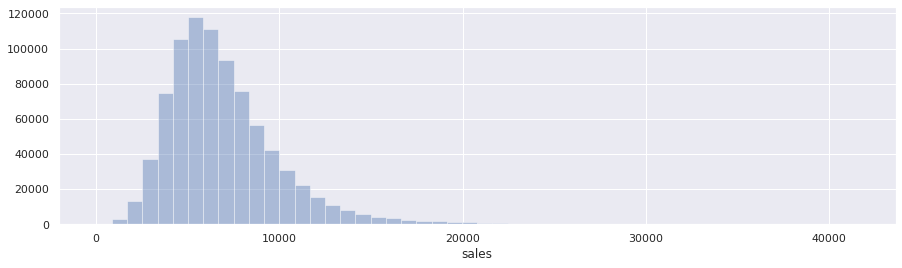

In [ ]:
# we will need to pre-process
plt.figure(figsize = (15, 4))
sns.distplot(df4['sales'], kde = False);

### 4.1.2. Numerical Variables

In [ ]:
num_feat = df4.select_dtypes( include = ['int64', 'float64'])

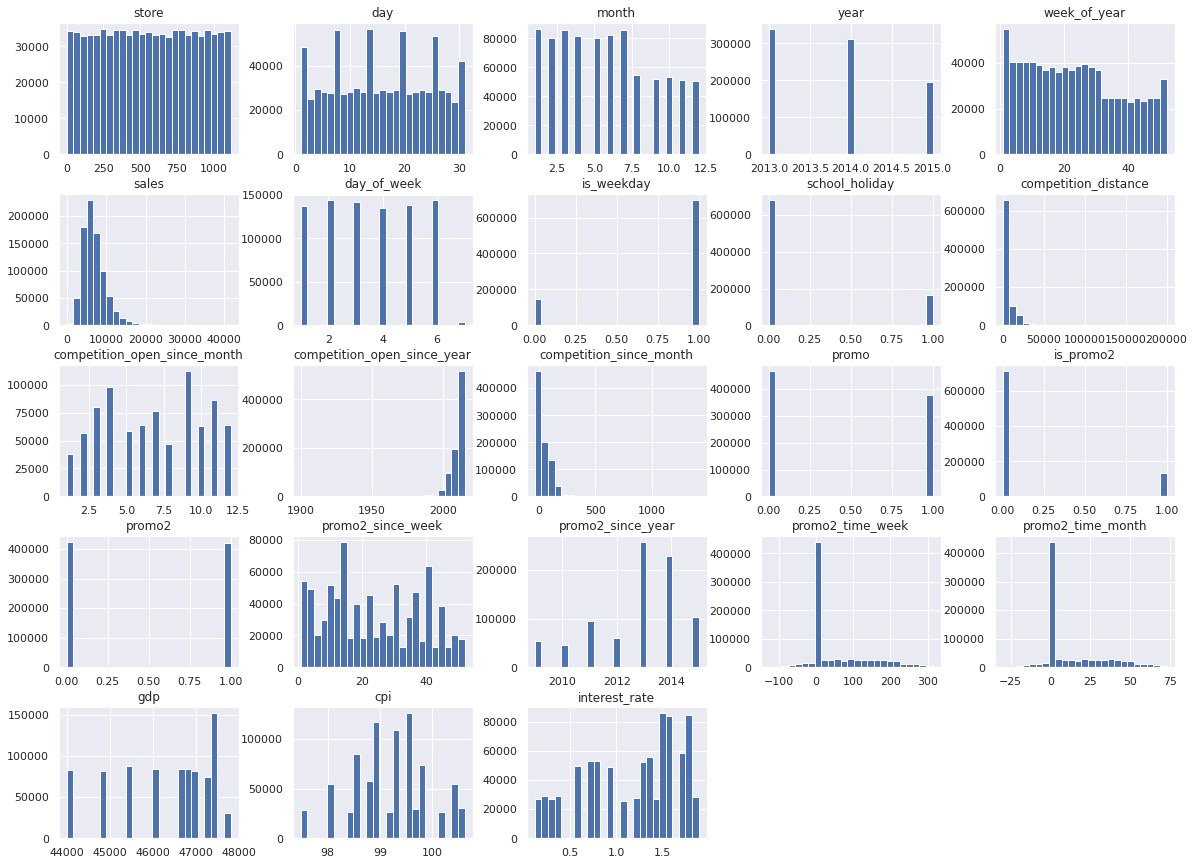

In [ ]:
num_feat.hist(bins = 25, figsize = (20,15));

 **Overall: All variables don't follow a normal distribution**  
 **day**: There are specific days which has almost double sales data points than others (day)  
 **month**: More sales data points on the first semester  
 **year**: Less data points in 2015 (compared to other years)  
 **week_of_year**: A boom of sales data points during the first weeks of the year  
 **day_of_week**: less sales data points on sundays    
 **is_weekday**: more sales data points on weekdays  
 **school_holiday**: more sales data points on regular days  
 **competition_distance**: more sales data points for stores with closer competitors  
 **competition_open_since_month**: more sales data points for competitors which entered competition on April, July, September  
 **competition_since_month**: no relevant info retrieved  
 **is_promo2**: more sales data points for 0  
 **competition_open_since_year, promo2, promo, promo_since, promo_time, gdp, cpi, interest_rates**: no relevant info retrieved  


### 4.1.3. Categorical Variables

In [ ]:
cat_feat = df4.select_dtypes(exclude = ['float64','int64'])
cat_feat.columns

Index(['date', 'year_month', 'year_week', 'state_holiday', 'store_type',
       'assortment', 'competition_since', 'promo2_since'],
      dtype='object')

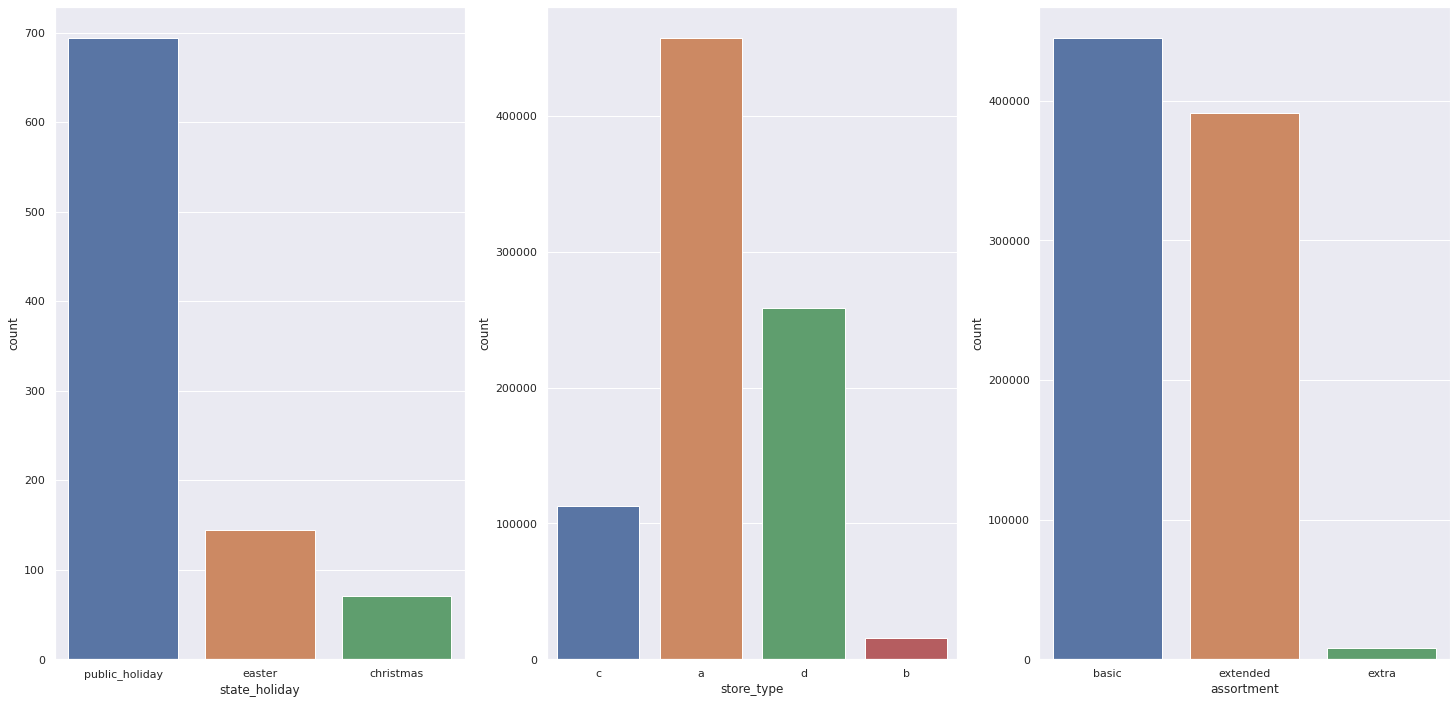

In [ ]:
# state_holiday
plt.subplot(1,3,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

# store_type
plt.subplot(1,3,2)
sns.countplot(df4['store_type']);

# assortment
plt.subplot(1,3,3)
sns.countplot(df4['assortment']);


 **state_holiday**: more sales data points on public_holidays than other holidays. Easter and Christmas are similar  
 **store_type**: More sales data points for store_type a. Less stores b  
 **assortment**: Less sales data points for assortment of type 'extra'  


## 4.2. Bivariate Analysis

### **H1.**  Stores with bigger assortment type (categorized as 'extra') sell more  
**False**: Stores with bigger assortment sell less. However, the number of data points for stores with assortment 'extra' is very low compared to the other two (refer to univariate analysis on 4.1.3. ). Since assortment 'extra' follows a similar sales pattern of the other two, we can assume that assortment wouldn't impact our predictions much.

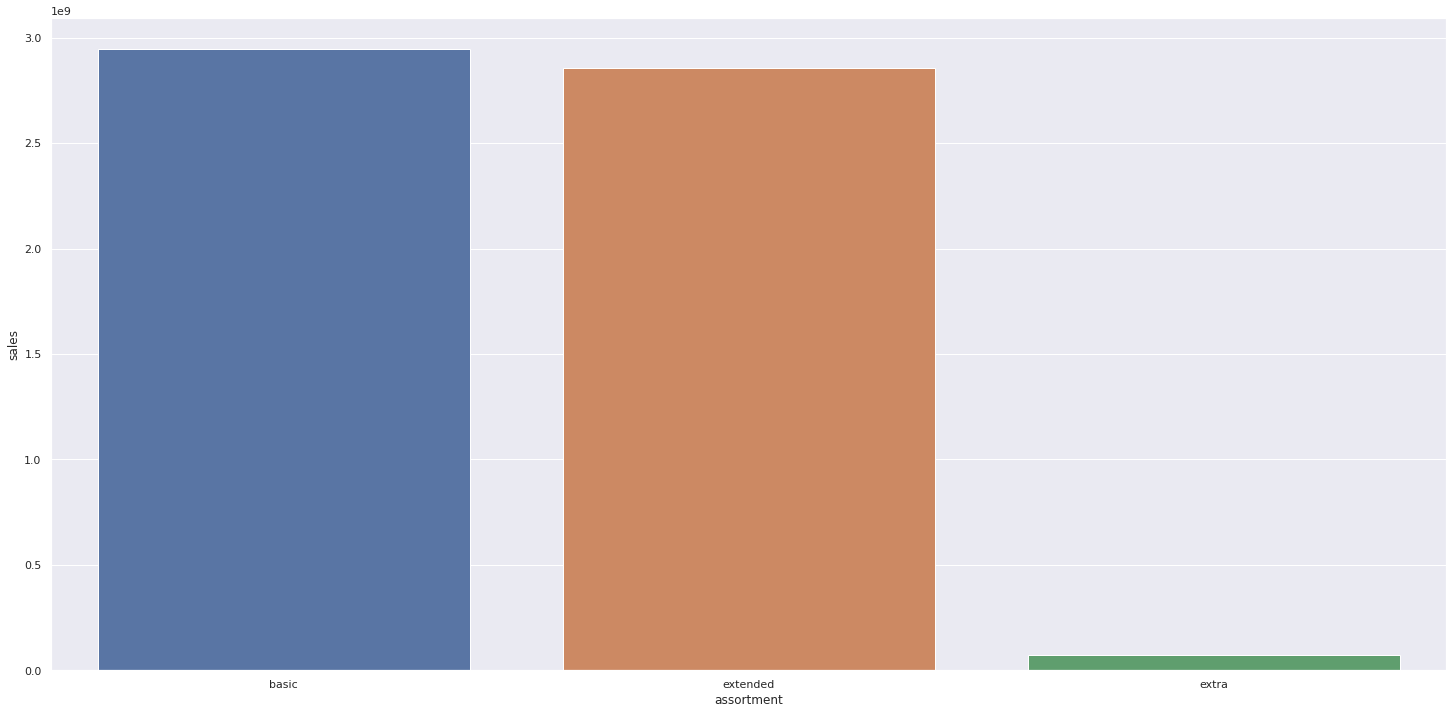

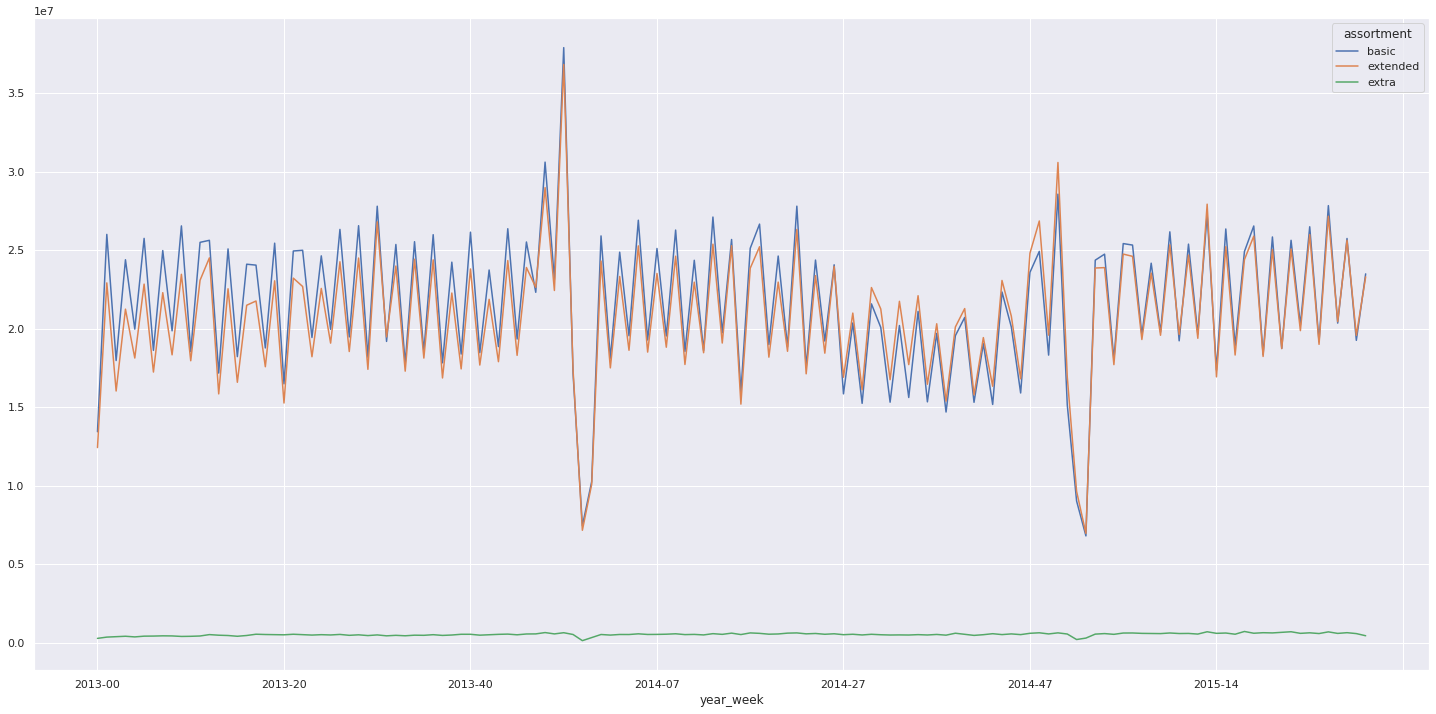

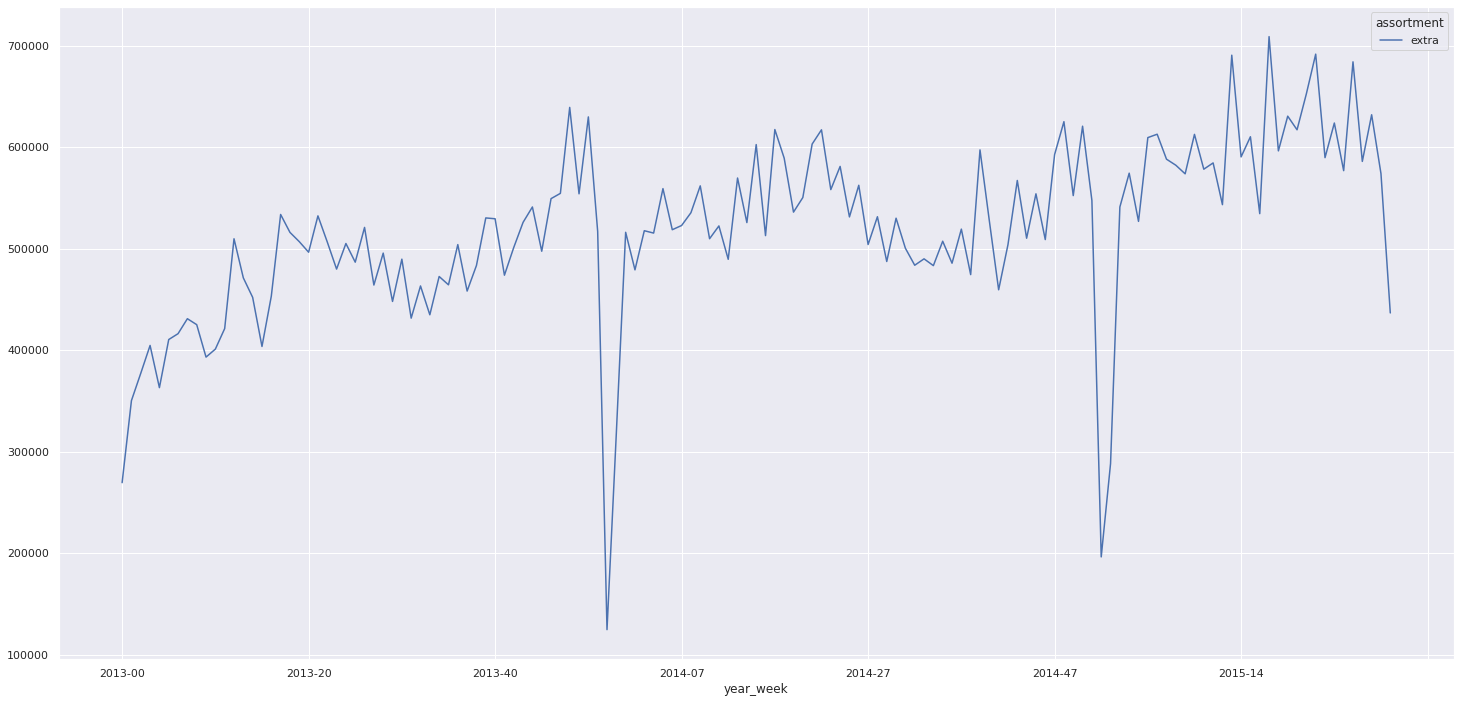

In [ ]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### **H2.**  Stores near competitors sell less  
**FALSE**: Stores near competitors sell more.

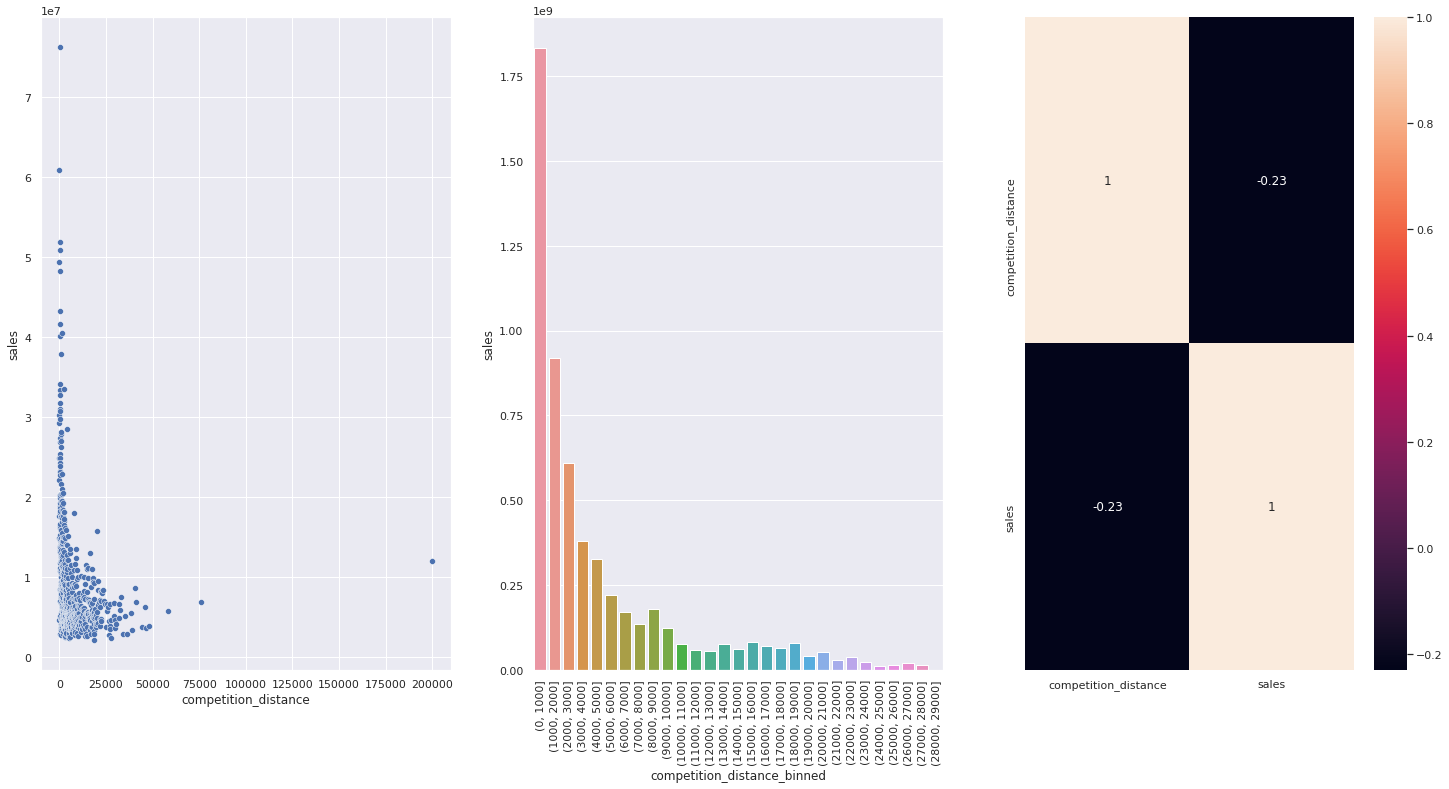

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,30000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot = True);
plt.show()

### **H3.**  Stores with newly opened competitors sell less than stores with old competitors  
**FALSE**: Stores with newly opened competitors sell more.

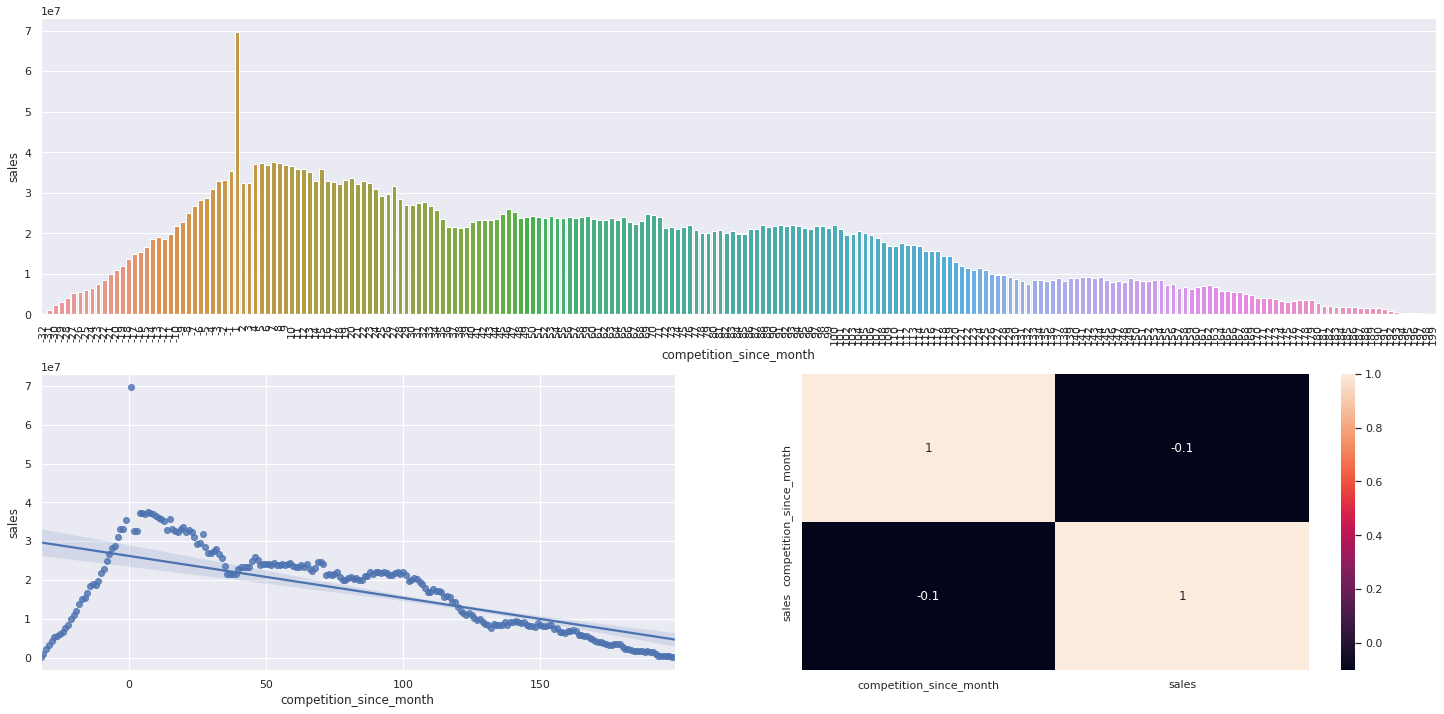

In [ ]:
grid = GridSpec( 2, 2 )

plt.subplot(grid[0,:])
aux1 = df4[['competition_since_month', 'sales']].groupby('competition_since_month').sum().reset_index()
aux2 = aux1[(aux1['competition_since_month'] != 0) & (aux1['competition_since_month'] < 200)]
sns.barplot(x = 'competition_since_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
sns.regplot(x = 'competition_since_month', y = 'sales', data = aux2)

plt.subplot(grid[1,1])
sns.heatmap(aux1.corr(), annot = True);

### **H4.**  Stores sell more on weekdays than weekends/holidays (sales rate)  
**TRUE**: Stores sell more on weekdays. Sales volume is also bigger on weekdays. Worst sales day is Sunday.

,Metrics,Results
0,Total Sales,5873180623
1,Total Sales Weekends,875869168
2,Avg Sales Weekends,5932.26
3,Total Sales Weekdays,4997311455
4,Avg Sales Weekdays,7172.9


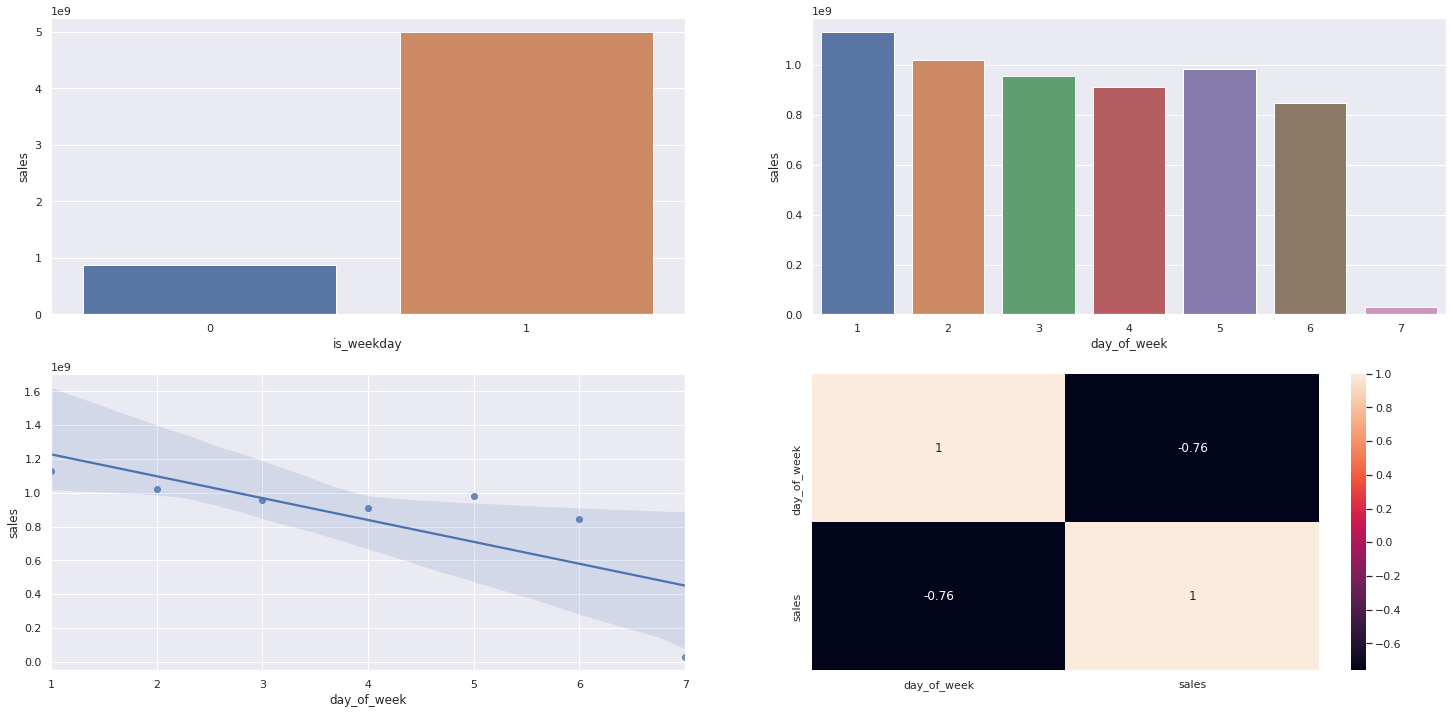

In [ ]:
aux1 = df4[['is_weekday','sales']].groupby('is_weekday').sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'is_weekday', y = 'sales', data = aux1);

plt.subplot(222)
aux8 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux8);

plt.subplot(223)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux8);

plt.subplot(224)
sns.heatmap(aux8.corr(), annot=True)

aux6 = df4['sales'].sum()
aux2 = df4[df4['is_weekday'] == 0]['sales'].sum()
aux3 = df4[df4['is_weekday'] == 1]['sales'].sum()
aux4 = str(round(df4[df4['is_weekday'] == 0]['sales'].mean(), 2))
aux5 = str(round(df4[df4['is_weekday'] == 1]['sales'].mean(), 2))

data = {'Metrics':['Total Sales', 'Total Sales Weekends','Avg Sales Weekends', 'Total Sales Weekdays',
                   'Avg Sales Weekdays'],'Results': [aux6, aux2, aux4, aux3, aux5]}

aux7 = pd.DataFrame(data)
aux7

### **H5.**  Stores sell more during the 2nd semester  
**FALSE**: Stores sell more on the 1st semester

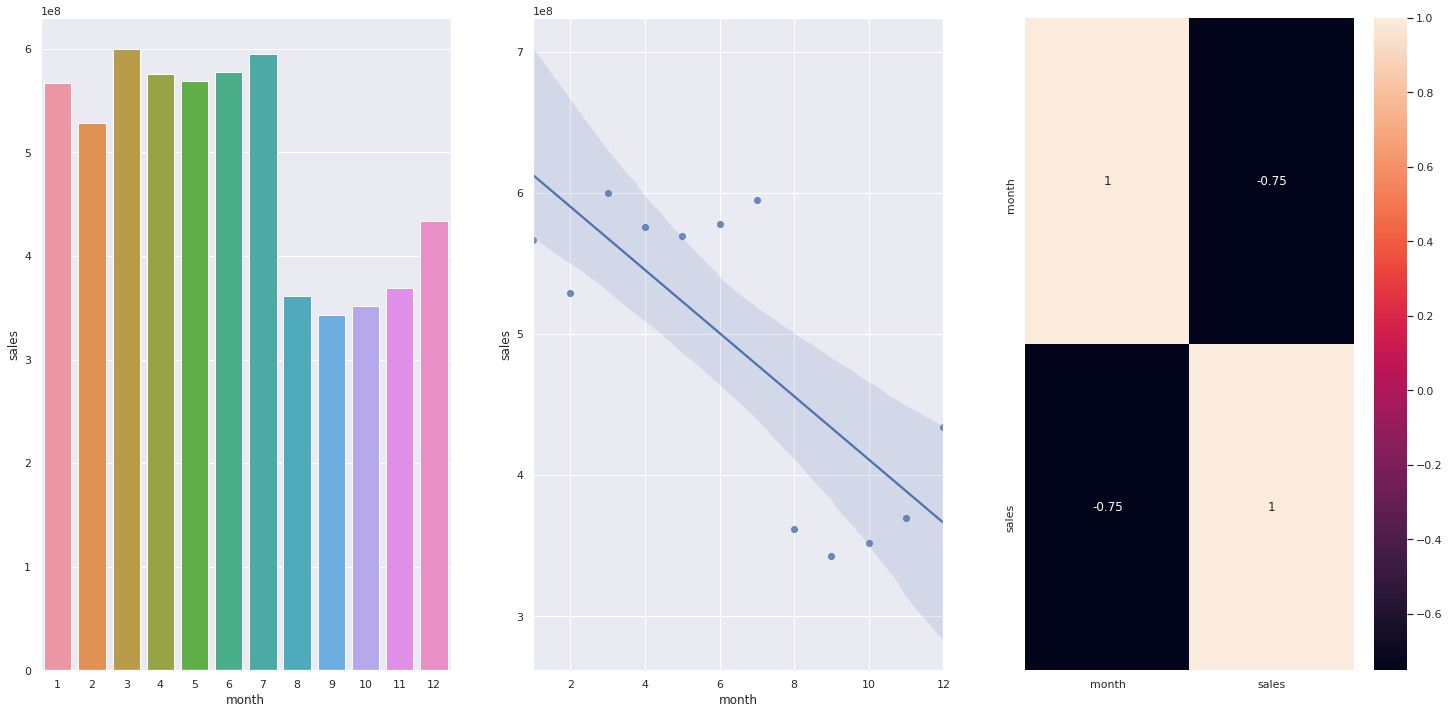

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot = True);

### **H6.**  Stores sell more during summer/winter breaks (schools)    
**FALSE**: School holidays in Germany are scattered throughout the year. The longest school holidays is the summer break in August and mid-September. DUring these months, stores sell less (refer to barplot above - H5)

### **H7.**  Stores sell less during school holidays  
**TRUE**: Stores sell less during school holidays except in August

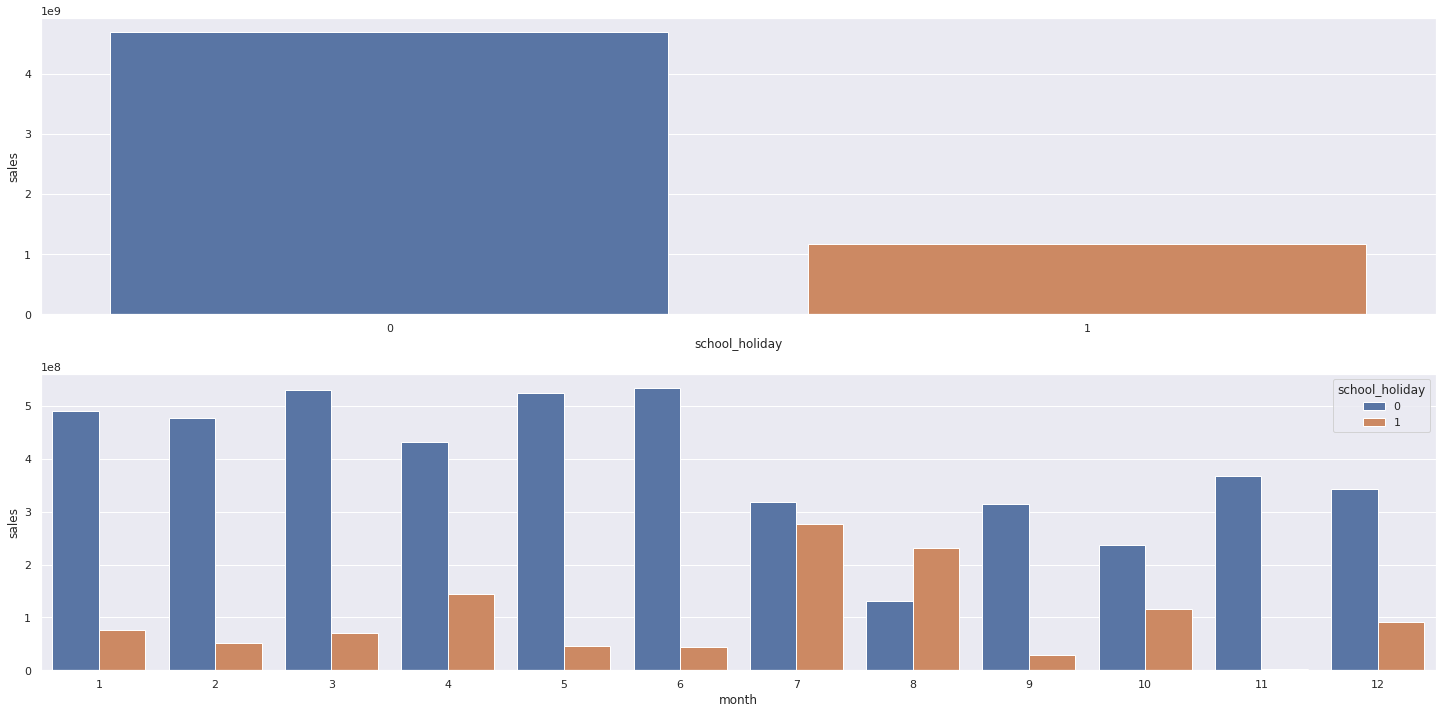

In [ ]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(211)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['school_holiday','sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
plt.subplot(212)
sns.barplot(x = 'month', y= 'sales' , hue = 'school_holiday', data = aux2);

### **H8.**  Stores sell more on Christmas than other holidays
**FALSE**: Stores sell more on public_holidays and Easter. However, our data doesn't capture christmas sales in 2015.

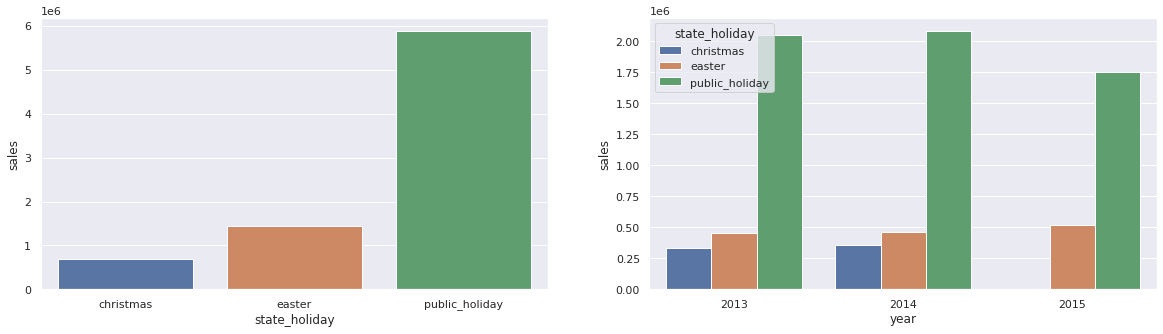

In [ ]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.figure(figsize = (20,5))
plt.subplot(121)
sns.barplot(x='state_holiday',y='sales',data=aux2);

aux3 = aux1[['state_holiday', 'sales','year']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(122)
sns.barplot(x='year',y='sales', hue = 'state_holiday', data=aux3);

### **H9.**  Stores are selling more along the years  
**FALSE**: Stores are selling less along the years. However, the year 2015 is not closed (dataset goes till April 2015)

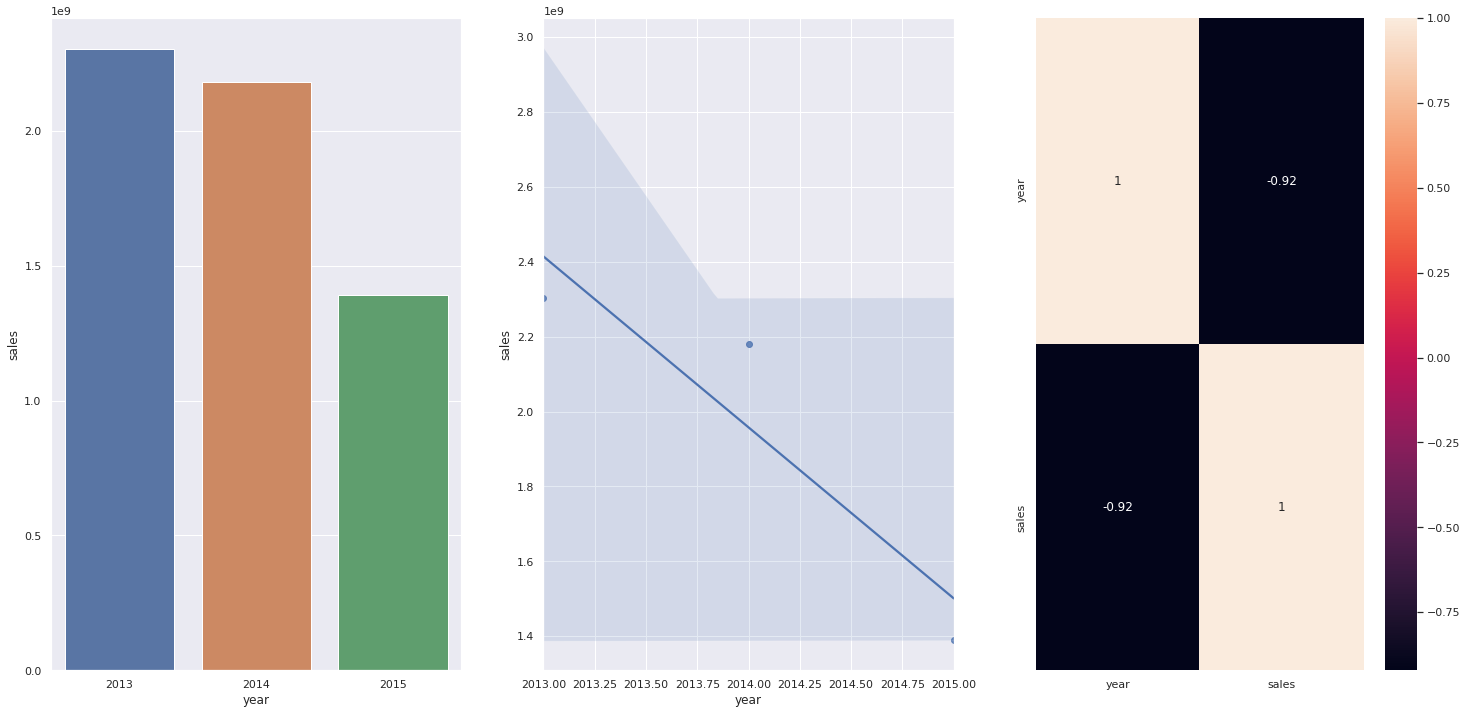

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(132)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(133)
sns.heatmap(aux1.corr(), annot = True);


### **H10.**  Stores sell more after day 10 of each month 
**TRUE**: Stores sell more after day 10. Not a surprise, since there are more days after day 10.

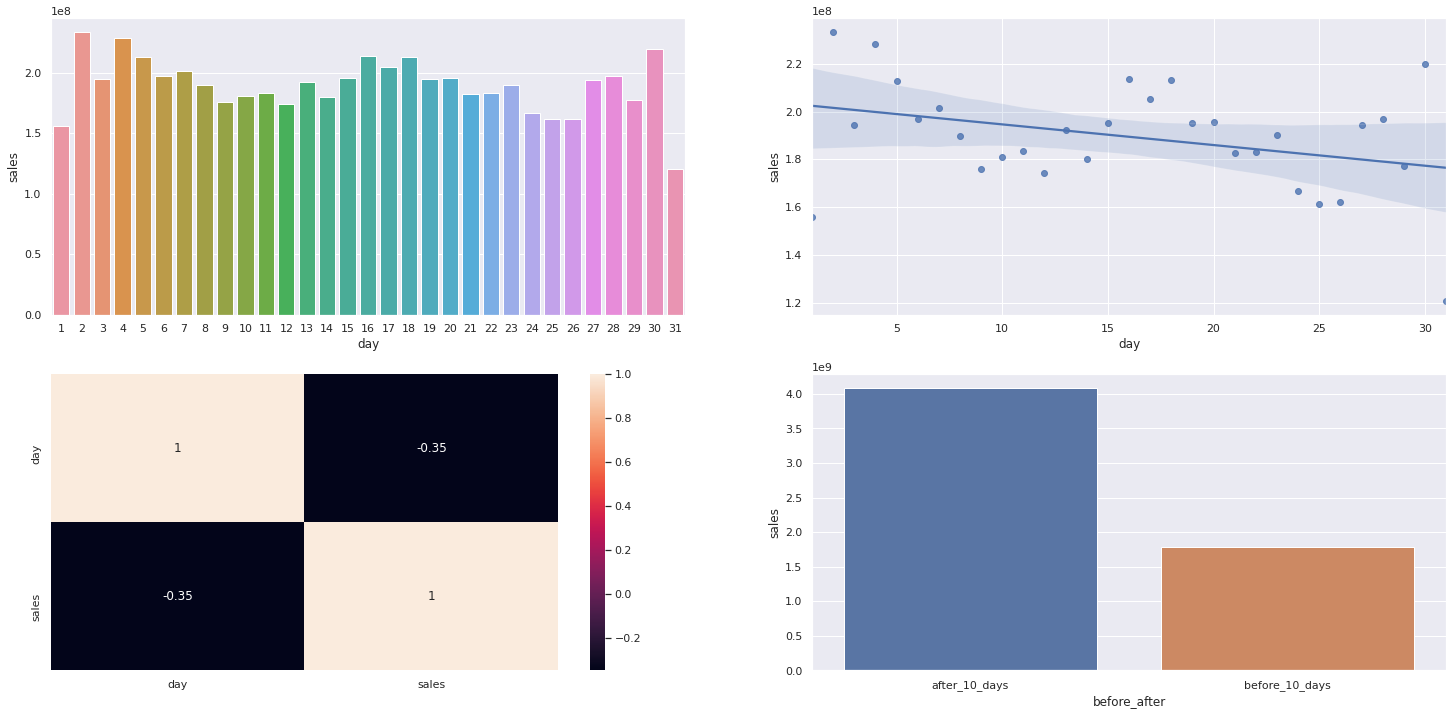

In [ ]:

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'day',y = 'sales', data = aux1);

plt.subplot(222)
sns.regplot(x = 'day',y = 'sales', data = aux1);

plt.subplot(223)
sns.heatmap(aux1.corr(), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10
                                         else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(224)
sns.barplot(x = 'before_after',y = 'sales', data = aux2);


### **H11.**  Stores frequently doing traditional promo sales sell more   
**TRUE**: Stores with more traditional promo sales days sell more. Correlation is weak, but we might want to add the number of traditional promo days per store as a new variable in the next cycle.

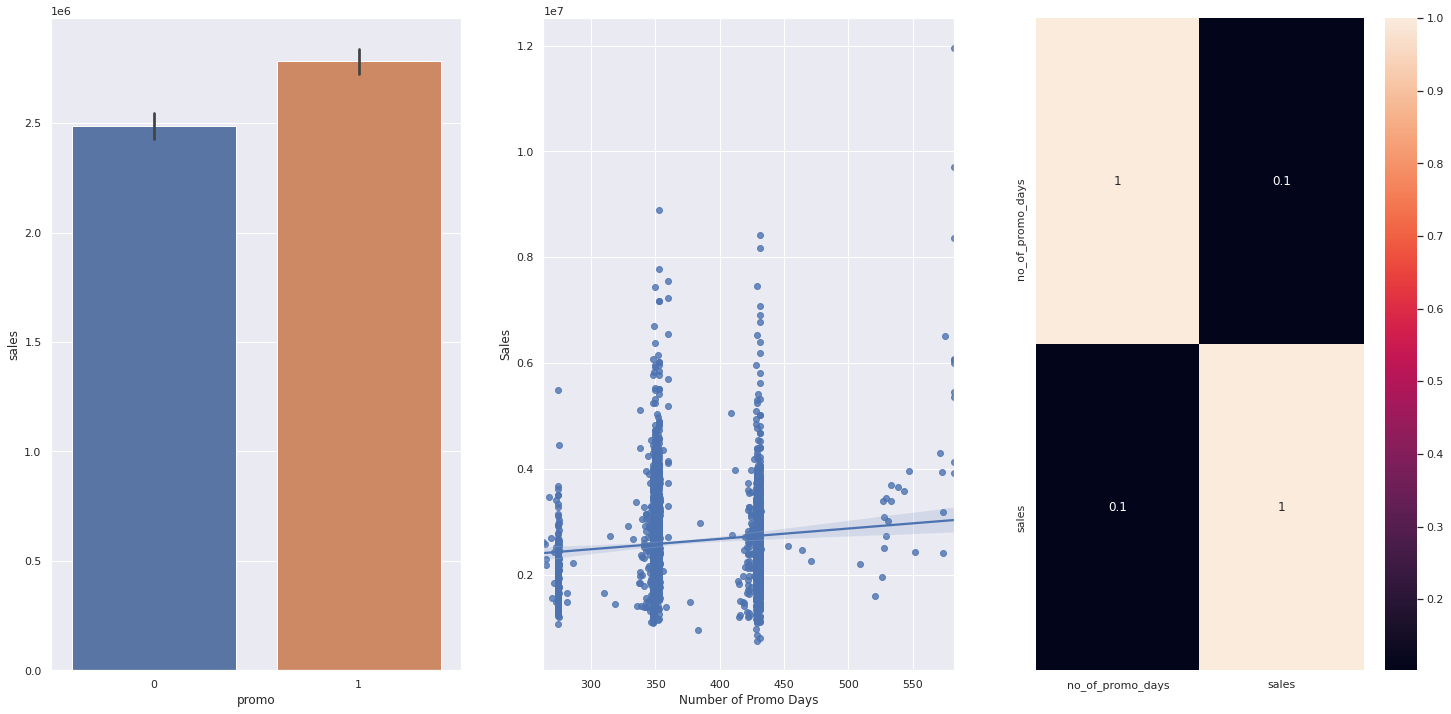

In [ ]:
aux1 = df4[['store','promo','sales']].groupby(['store','promo']).sum().reset_index()
plt.subplot(131)
sns.barplot(x = 'promo', y = 'sales', data = aux1);

plt.subplot(132)
aux3 = df4[['store','promo','sales']].groupby(['store','promo']).count().reset_index()
aux1['no_of_promo_days'] = aux3['sales']

sns.regplot(x = 'no_of_promo_days', y = 'sales', data = aux1);
plt.xlabel('Number of Promo Days');
plt.ylabel('Sales');
 

plt.subplot(133)
aux2 = aux1[['no_of_promo_days','sales']]
sns.heatmap(aux2.corr(), annot = True);


### **H12.**  Stores doing consecutive promo sales in the beginning of the year sell more 
**TRUE**: Stores with consecutive promo sales sell more in the beginning of the year. However, sales are unstable for February.

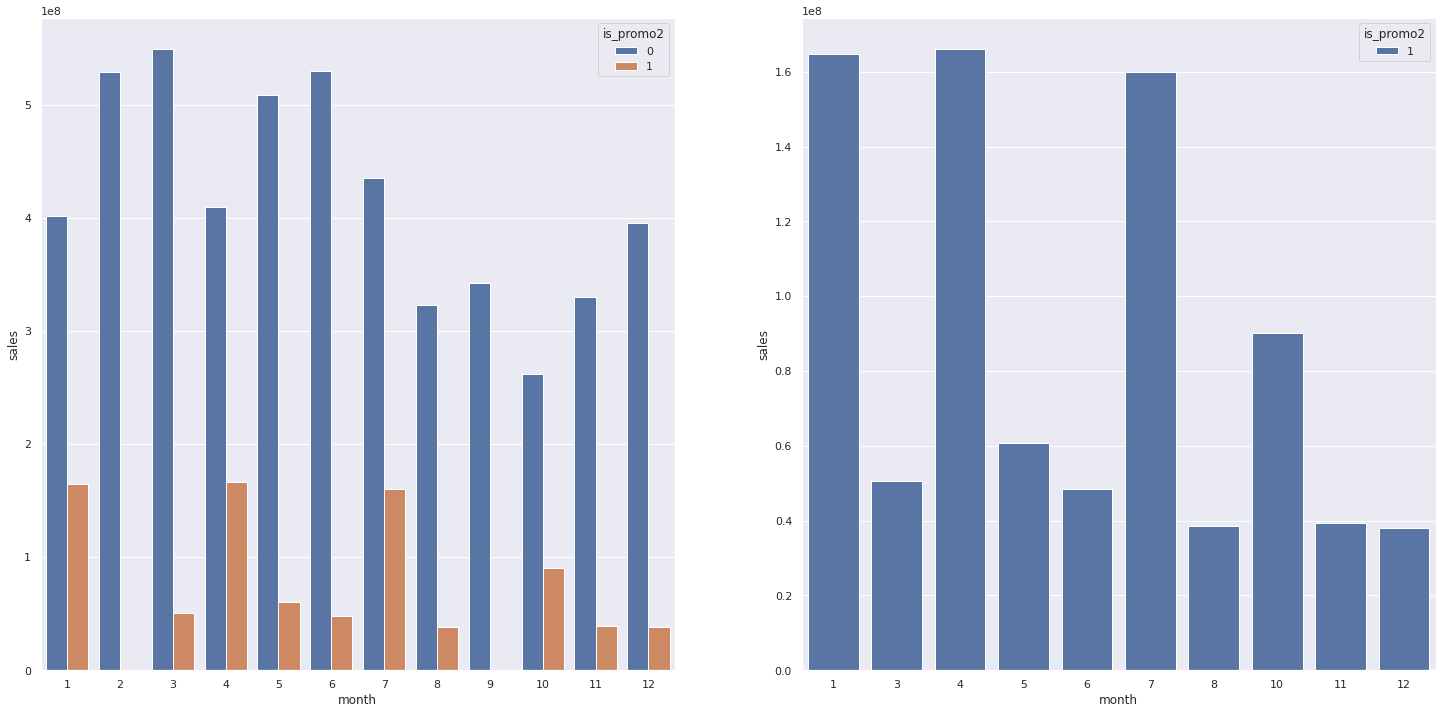

In [ ]:
aux1 = df4[['sales','month','is_promo2']].groupby(['is_promo2','month']).sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'month', y = 'sales', hue = 'is_promo2', data = aux1);

aux2 = aux1[aux1['is_promo2'] == 1]
plt.subplot(122)
sns.barplot(x = 'month', y = 'sales', hue = 'is_promo2', data = aux2);


### **H13.**  Stores participating in consecutive promo for a longer time sell more 
**FALSE**: Stores participating in consecutive promo for a longer time sell less. For next cycle, we can split promo2_time_week into two variables (before and after promo).

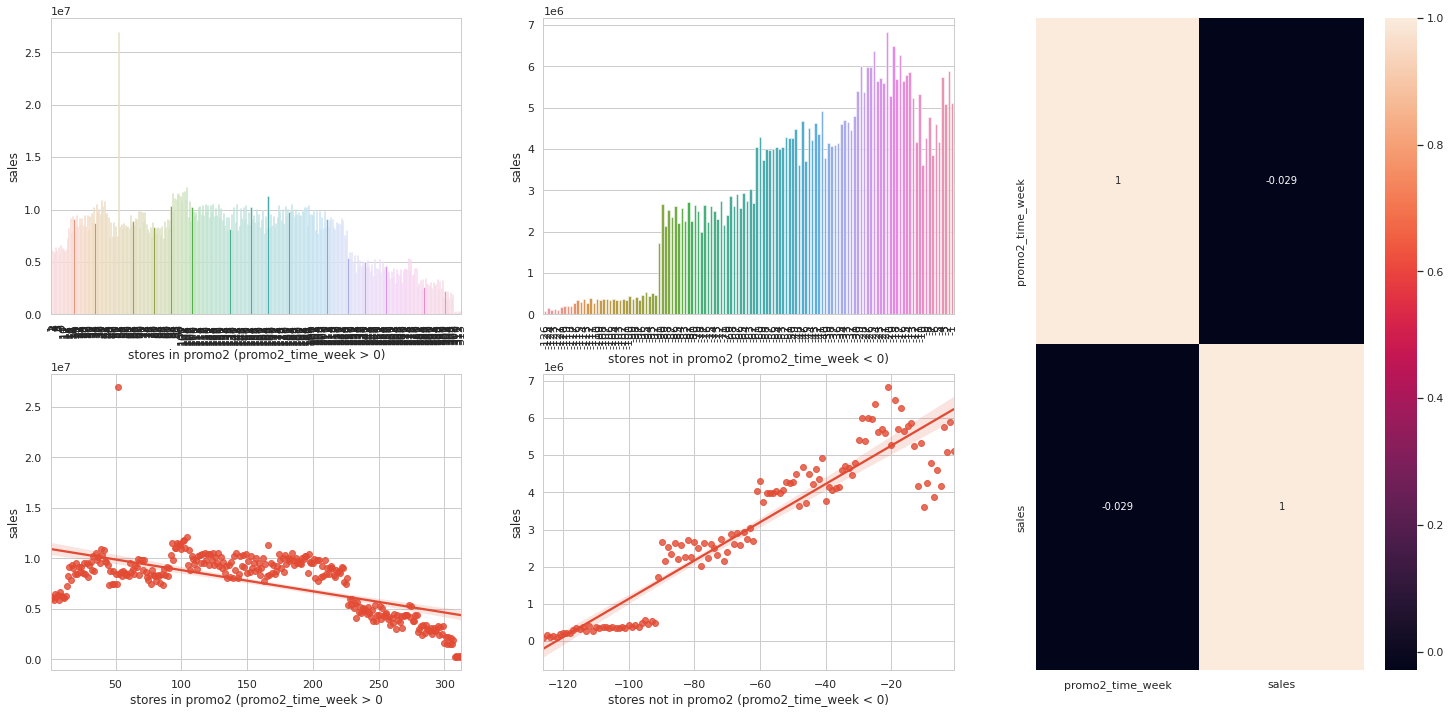

In [ ]:
aux1 = df4[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo2_time_week'] > 0] # consecutive promo
sns.barplot(x = 'promo2_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.xlabel('stores in promo2 (promo2_time_week > 0)')

plt.subplot(grid[0,1])
aux3 = aux1[aux1['promo2_time_week'] < 0] # regular promo
sns.barplot(x = 'promo2_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);
plt.xlabel('stores not in promo2 (promo2_time_week < 0)')

plt.subplot(grid[1,0])
sns.regplot(x = 'promo2_time_week', y = 'sales', data = aux2);
plt.xlabel('stores in promo2 (promo2_time_week > 0')

plt.subplot(grid[1,1])
sns.regplot(x = 'promo2_time_week', y = 'sales', data = aux3);
plt.xlabel('stores not in promo2 (promo2_time_week < 0)')

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H14.**  Stores with more consecutive promo sale days sell more  
**TRUE**: Stores with more consecutive promo days sell more. However, sales volume is bigger for days with no consecutive promotion   
OBS: It might be worth including number of consecutive promo days as a variable in the model. We will add this depending on the ML performance.

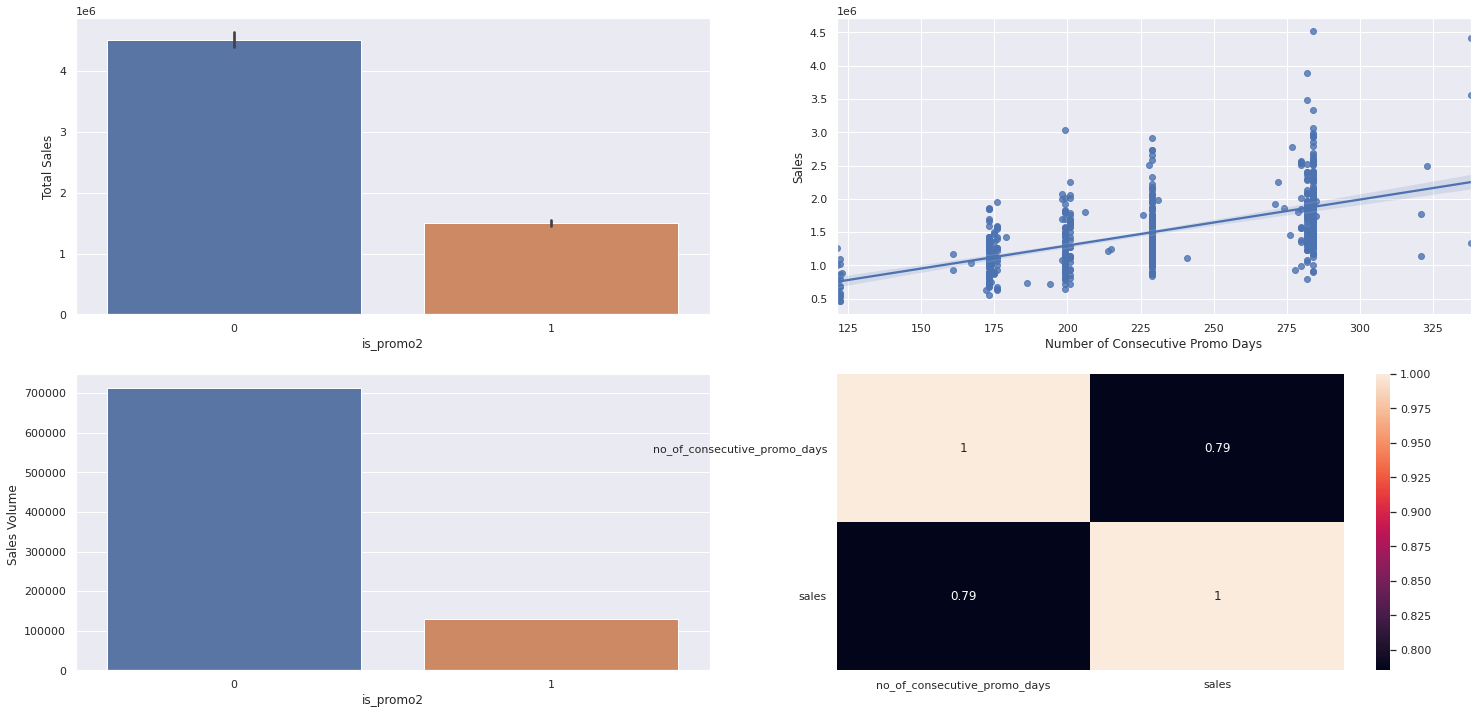

In [ ]:
aux1 = df4[['store','is_promo2','sales']].groupby(['store','is_promo2']).sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'is_promo2', y = 'sales', data = aux1);
plt.ylabel('Total Sales');

plt.subplot(222)
aux3 = df4[['store','is_promo2','sales']].groupby(['store','is_promo2']).count().reset_index()
aux1['no_of_consecutive_promo_days'] = aux3['sales']
aux4 = aux1[aux1['is_promo2'] == 1]
sns.regplot(x = 'no_of_consecutive_promo_days', y = 'sales', data = aux4);
plt.xlabel('Number of Consecutive Promo Days');
plt.ylabel('Sales');
 
plt.subplot(223)
aux5 = aux1[['is_promo2','no_of_consecutive_promo_days']].groupby('is_promo2').sum().reset_index()
sns.barplot(x = 'is_promo2', y = 'no_of_consecutive_promo_days', data = aux5);
plt.ylabel('Sales Volume ');

plt.subplot(224)
aux2 = aux1[['no_of_consecutive_promo_days','sales']]
sns.heatmap(aux2.corr(), annot = True);


### **H15.**  Stores sales increase when GDPpc increases (month)   
**FALSE**: Store sales neither increase nor decrease with GDPpc fluctuations over time. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.

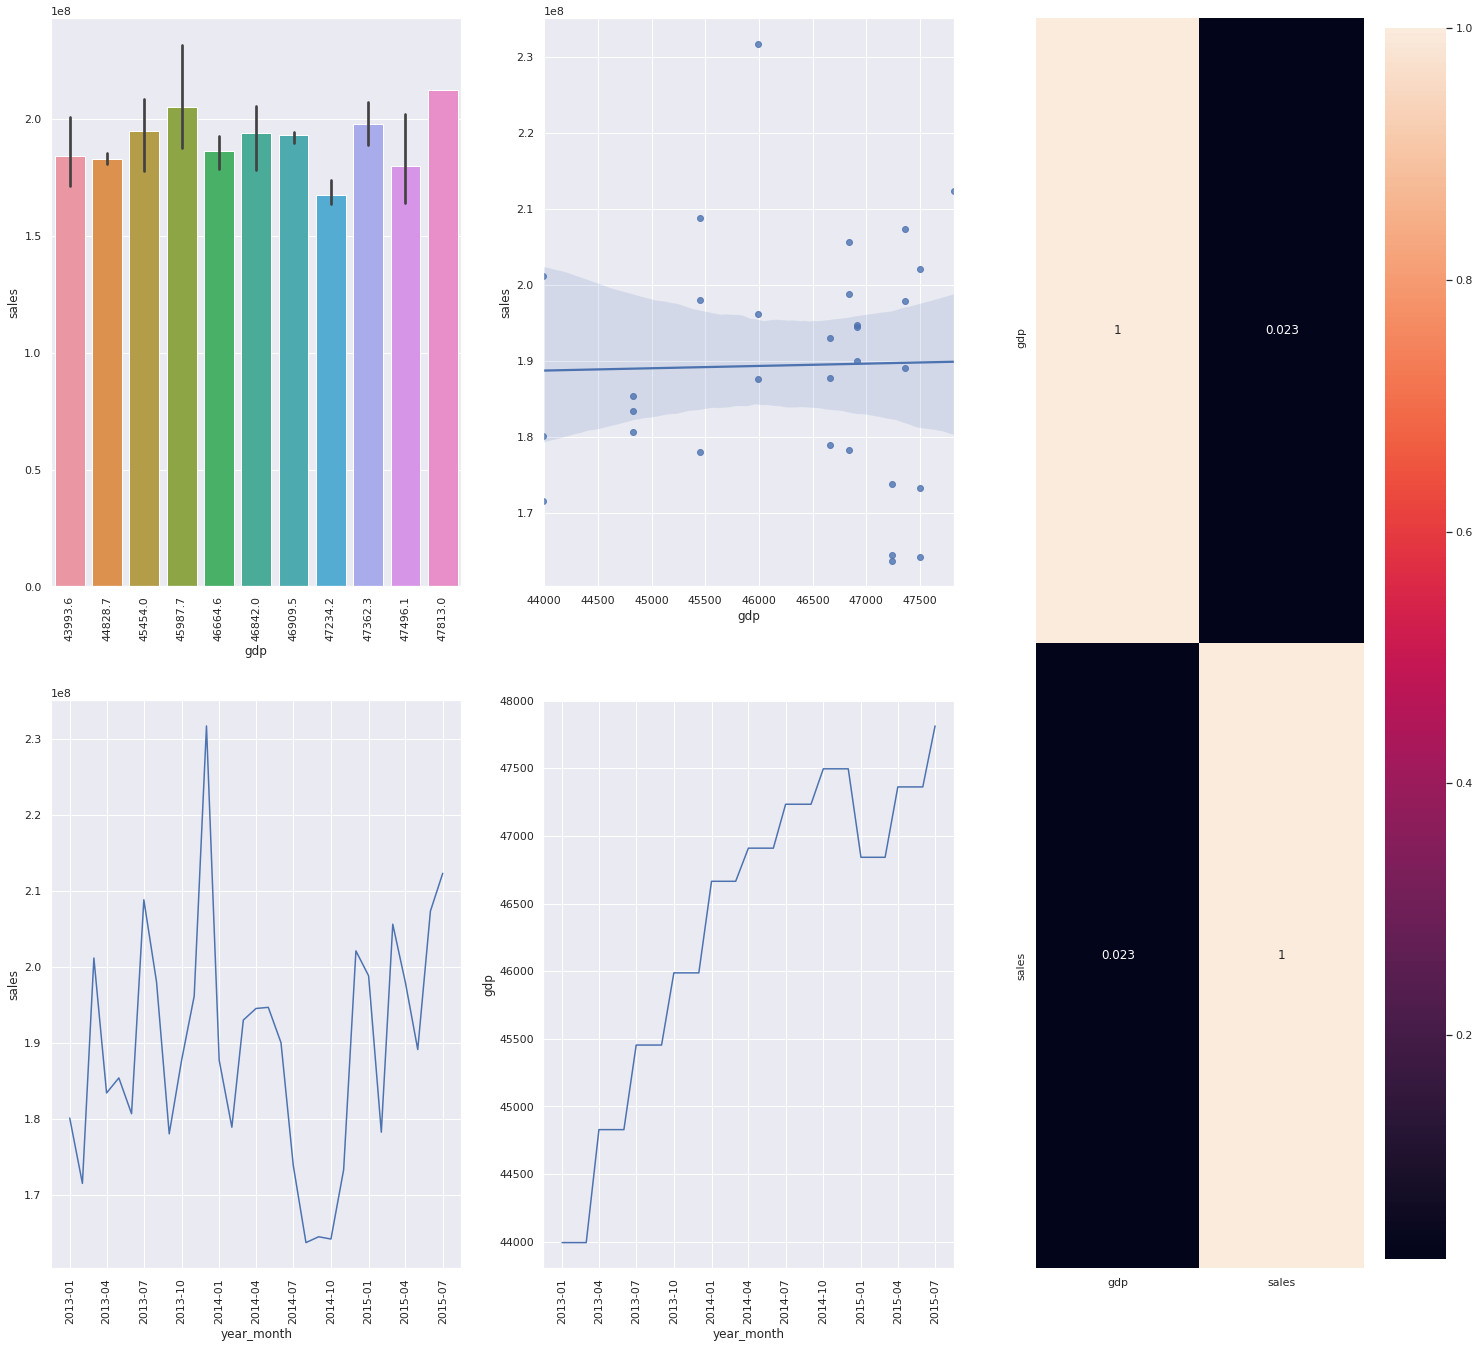

In [ ]:
aux1 = df4[['year_month', 'gdp','sales']].groupby(['year_month','gdp']).sum().reset_index()

grid = GridSpec(2,3)
plt.figure(figsize = (25,23))
plt.subplot(grid[0,0])
sns.barplot(x = 'gdp', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'gdp', y = 'sales', data = aux1);

plt.subplot(grid[1,0])
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
aux2 = aux1[['gdp','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(grid[1,1])
sns.lineplot(x = 'year_month', y = 'gdp', data = aux1);
plt.xticks(rotation = 90);



### **H16.**  Stores sales increase when interest rates decrease (month)  
**FALSE**: Store sales neither increase nor decrease with interest rate fluctuations over time. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.


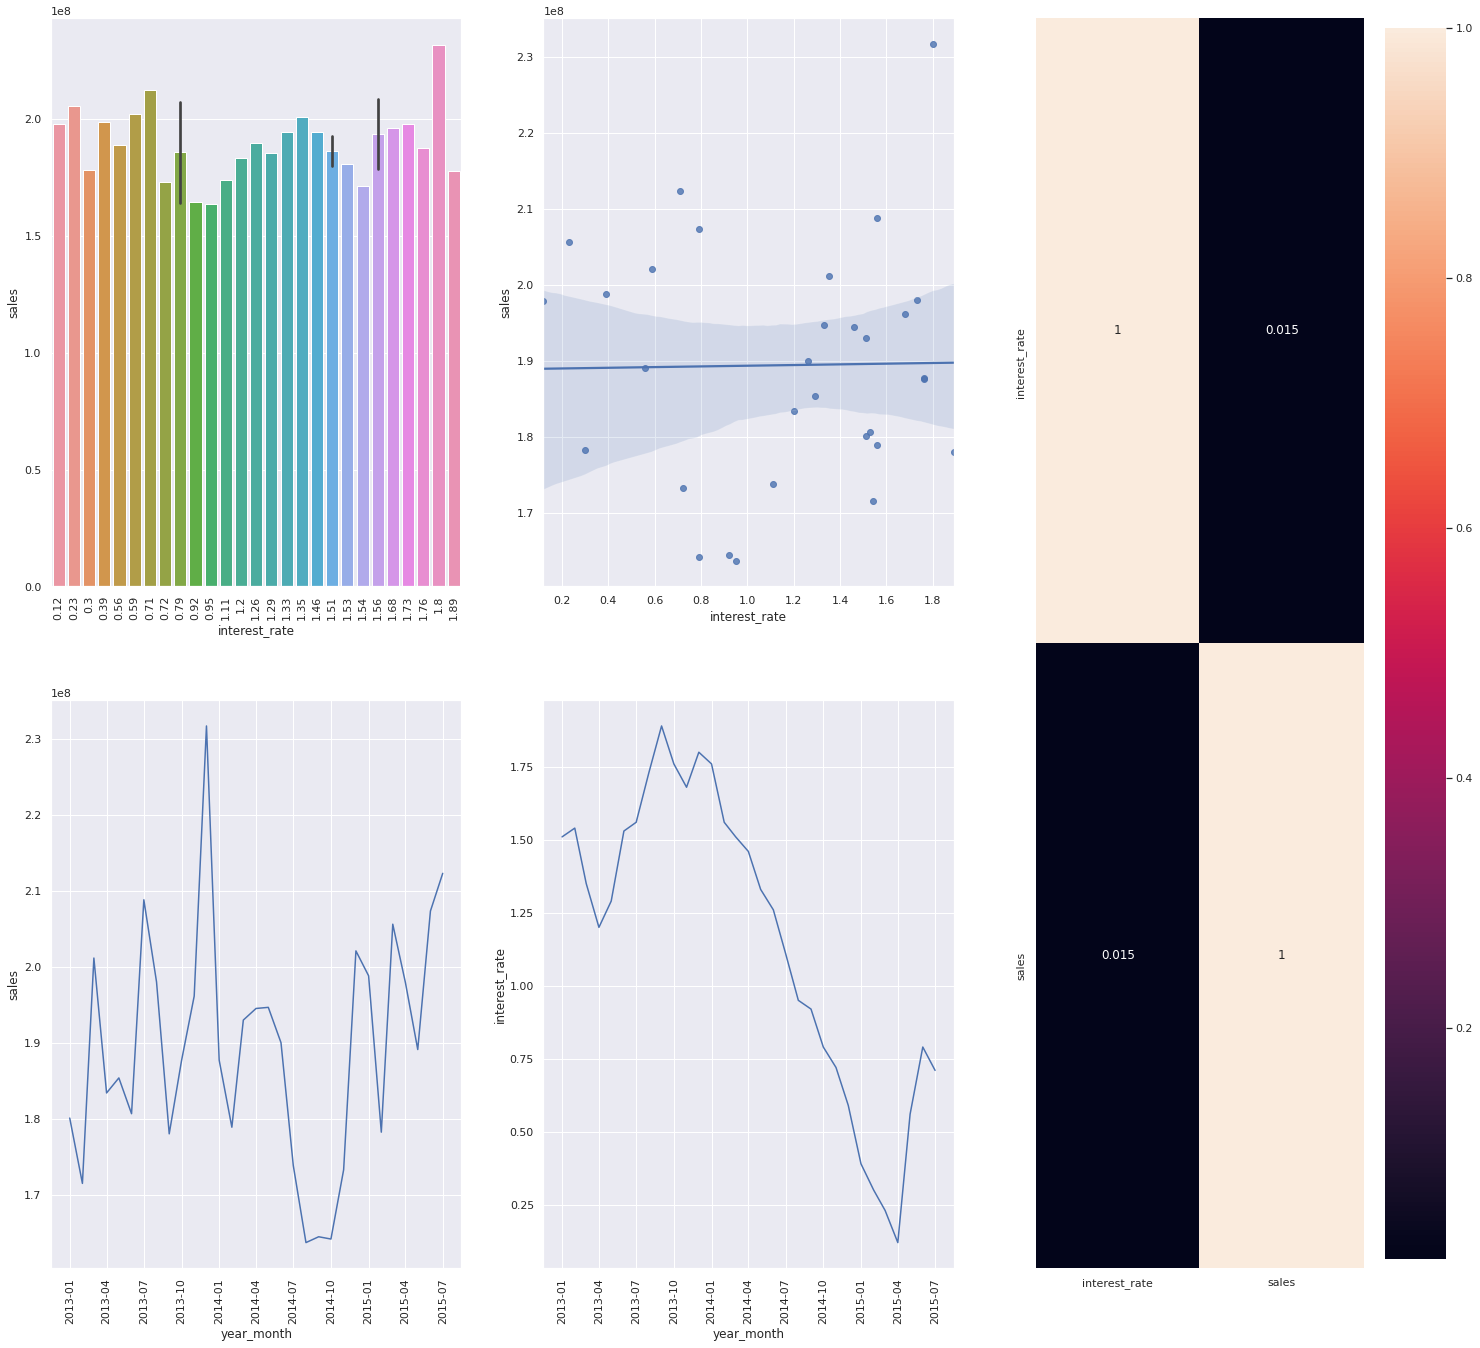

In [ ]:
aux1 = df4[['year_month', 'interest_rate','sales']].groupby(['year_month','interest_rate']).sum().reset_index()

grid = GridSpec(2,3)

plt.figure(figsize = (25,23))

plt.subplot(grid[0,0])
sns.barplot(x = 'interest_rate', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'interest_rate', y = 'sales', data = aux1);

plt.subplot(grid[1,0])
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
aux2 = aux1[['interest_rate','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(grid[1,1])
sns.lineplot(x = 'year_month', y = 'interest_rate', data = aux1);
plt.xticks(rotation = 90);

### **H17.**  Stores sales increase when Consumer Price Index (CPI) rate increases (month)  
**TRUE**: Store sales increase when inflation increases.

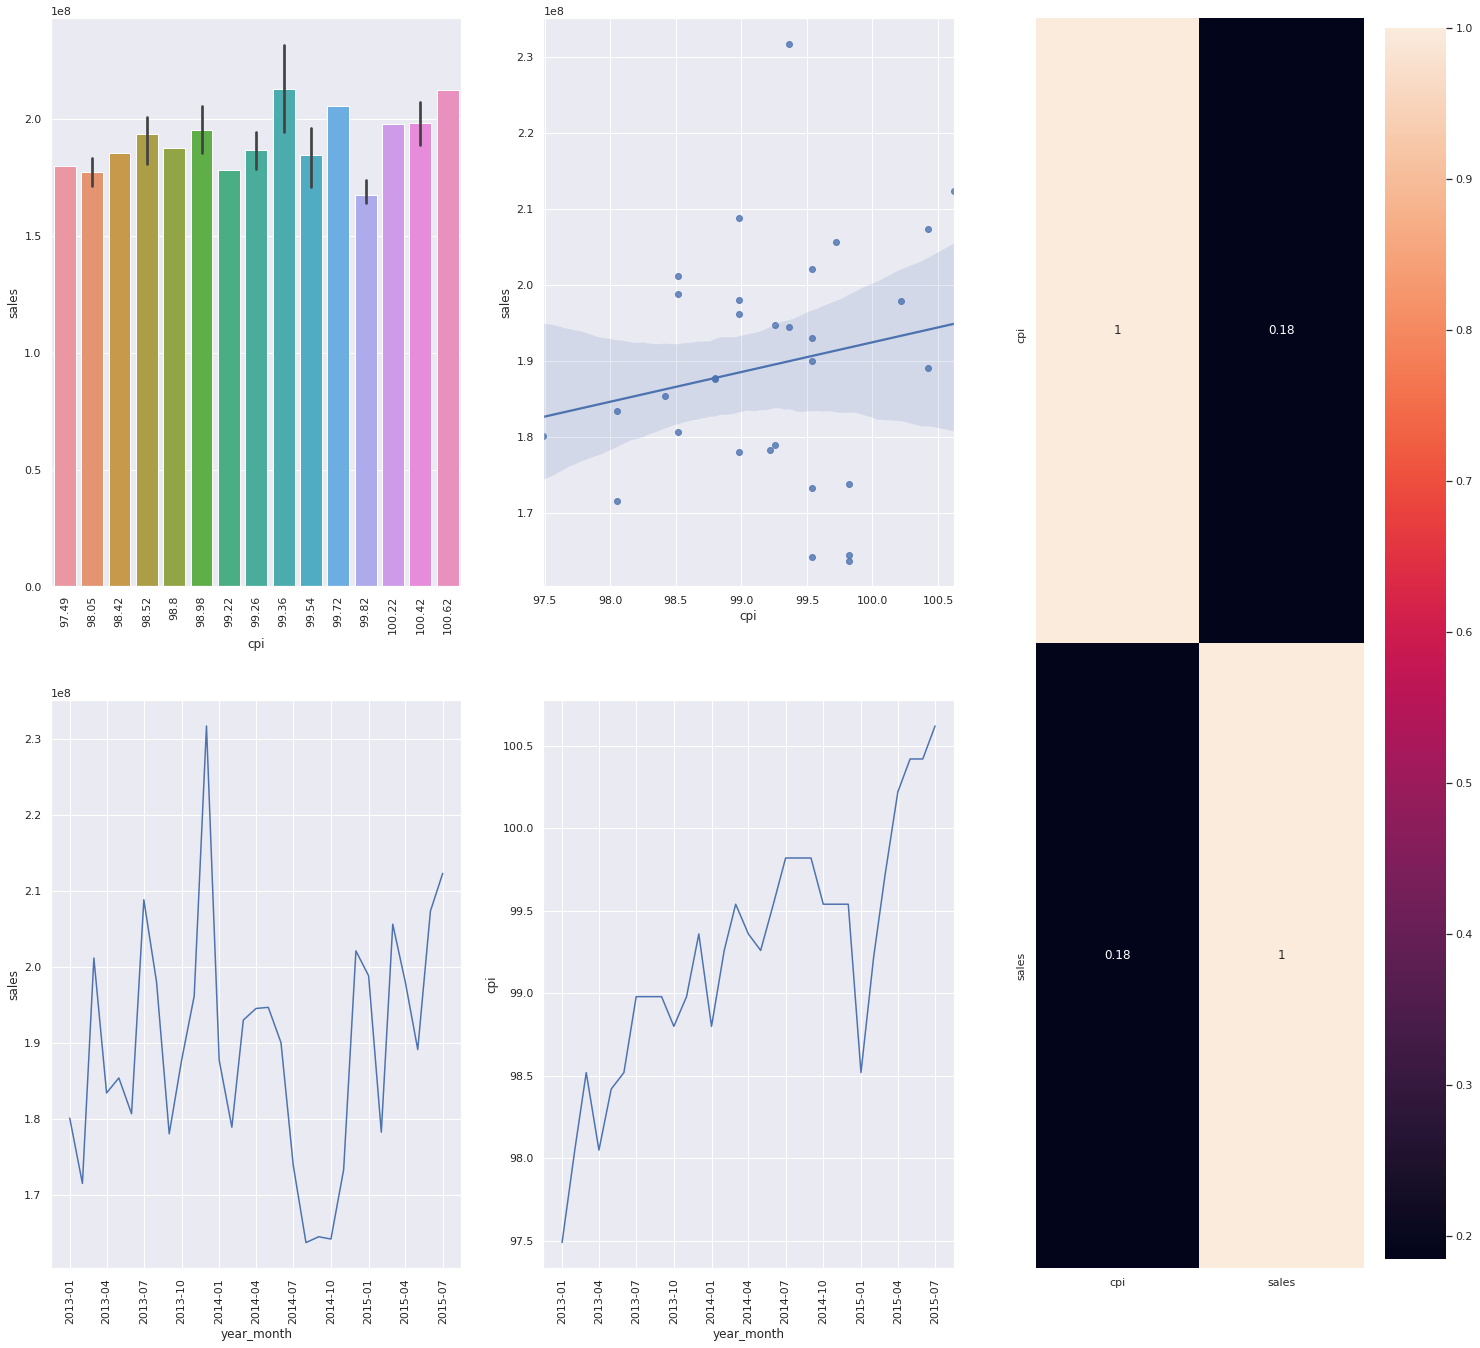

In [ ]:
aux1 = df4[['year_month', 'cpi','sales']].groupby(['year_month','cpi']).sum().reset_index()

grid = GridSpec(2,3)

plt.figure(figsize = (25,23))

plt.subplot(grid[0,0])
aux3 = aux1
aux3['cpi'] = round(aux3['cpi'], 2)
sns.barplot(x = 'cpi', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'cpi', y = 'sales', data = aux1);

plt.subplot(grid[1,0])
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
aux2 = aux1[['cpi','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(grid[1,1])
sns.lineplot(x = 'year_month', y = 'cpi', data = aux1);
plt.xticks(rotation = 90);

### 4.3. Hypotheses Validation

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hypothesis', 'Result', 'Relevancy'],
      ['H1', 'False', 'High'],  
      ['H2', 'False', 'High'],  
      ['H3', 'False', 'High'],
      ['H4', 'True', 'High'],
      ['H5', 'False', 'Medium'],
      ['H6', 'False', 'Low'],
      ['H7', 'True', 'Low'],
      ['H8', 'False', 'Medium'],
      ['H9', 'False', 'Medium'],
      ['H10', 'True', 'Low'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low'],
      ['H13', 'False', 'High'],
      ['H14', 'True', 'High'],
      ['H15', 'False', 'Low'],
      ['H16', 'False', 'Low'],
      ['H17', 'True', 'Low'],
     ]  
print( tabulate( tab, headers='firstrow' ) )



Hypothesis    Result    Relevancy
------------  --------  -----------
H1            False     High
H2            False     High
H3            False     High
H4            True      High
H5            False     Medium
H6            False     Low
H7            True      Low
H8            False     Medium
H9            False     Medium
H10           True      Low
H11           True      High
H12           True      Low
H13           False     High
H14           True      High
H15           False     Low
H16           False     Low
H17           True      Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

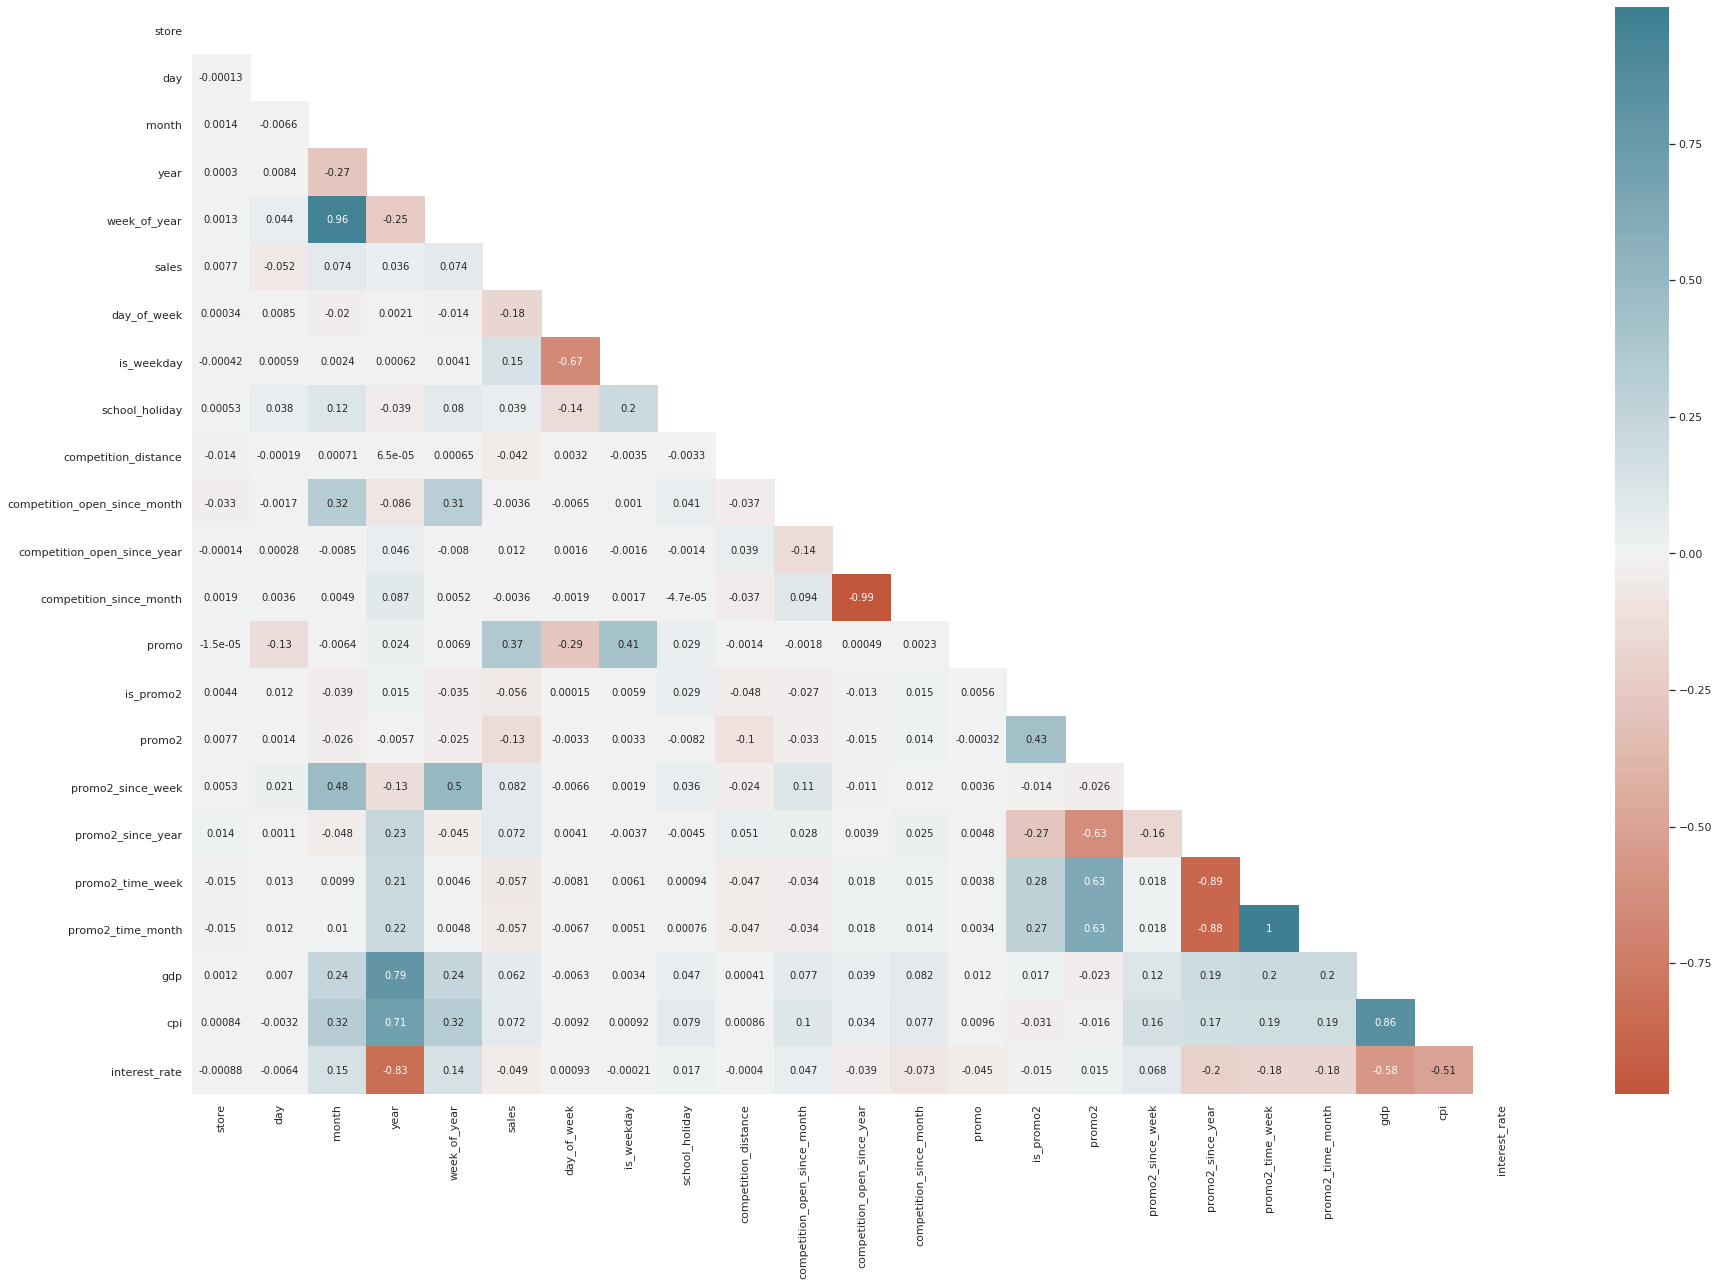

In [ ]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(num_feat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(num_feat.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );


**Multicollinearity**  
Negative correlation:  
1. competition_open_since_year vs competition_open_since_month    
2. year vs interest_rate  
3. promo2_since_year vs promo2_time_month  
4. promo2_since_year vs promo2_time_week  
5. day_of_week vs is_weekday  
  
Positive correlation:  
1. month vs week_of_year  
2. gdp vs year  
3. cpi vs year  
4. gdp vs cpi  
5. promo2 vs promo2_time_week  
6. promo2 vs promo2_time_month  

**Correlation with sales**
Strong: -  
Medium: promo  
Weak: is_weekday  
Around zero but positive: school_holiday, gdp, cpi, promo2_since_year, promo2_since_week, competition_open_since_year  

### 4.3.1. Categorical Variables

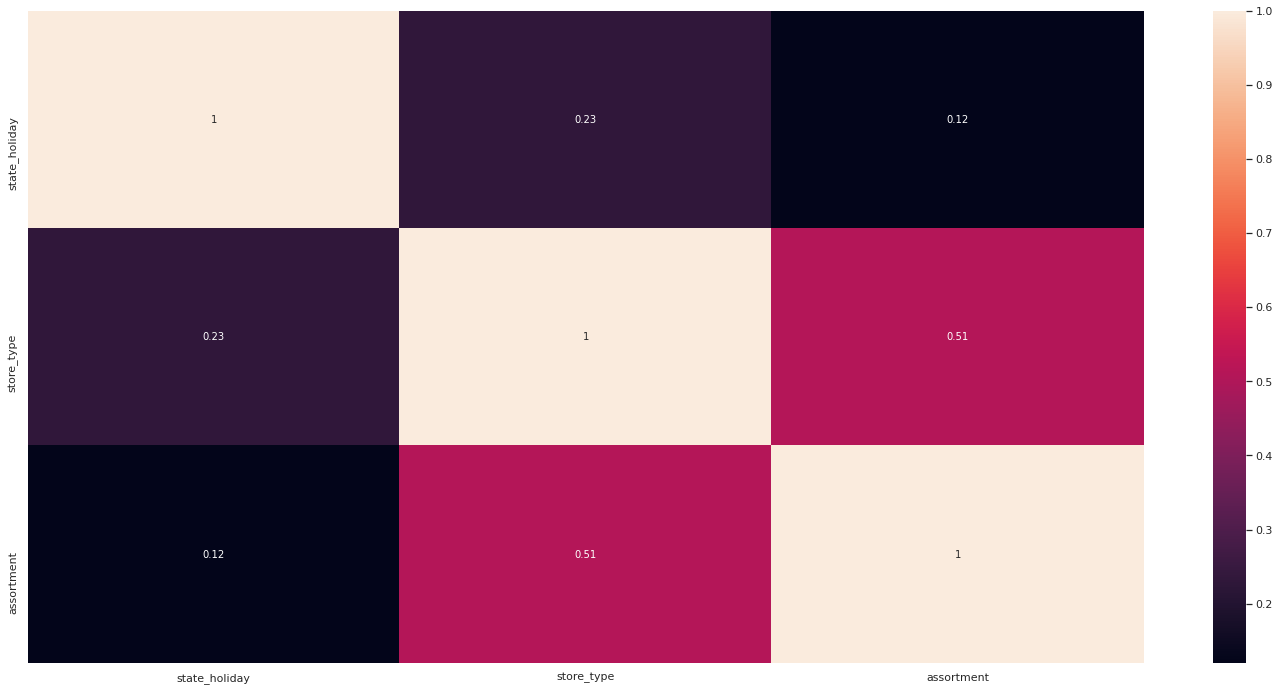

In [ ]:
# calculating cramer_V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap( d, annot=True );

**Multicollinearity**  
1. store_type and assortment have a mild correlation

# 5.0. STEP 05 - DATA PRE-PROCESSING

In [128]:
# copy previous dataset
df5 = df4.copy()

In [129]:
# check dtypes
df5.dtypes

store                                    int64
date                            datetime64[ns]
day                                      int64
month                                    int64
year                                     int64
year_month                      datetime64[ns]
week_of_year                             int64
year_week                               object
sales                                    int64
day_of_week                              int64
is_weekday                               int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
competition_since               datetime64[ns]
competition_since_month                  int64
promo                                    int64
is_promo2    

## 5.1. Standardization
No variable to be standardized

## 5.2. Rescaling

In [130]:
# use Robust and Min-Max Scaler
rs = RobustScaler()
mms = MinMaxScaler()

In [131]:
## RobustScaler
# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
# competition_since_month (months of competition since it started)
df5['competition_since_month'] = rs.fit_transform( df5[['competition_since_month']].values)

## MinMaxScaler
# promo2_time_week (weeks of promo2 since it started)
df5['promo2_time_week'] = mms.fit_transform( df5[['promo2_time_week']].values)
# promo2_time_month (months of promo2 since it started)
df5['promo2_time_month'] = mms.fit_transform( df5[['promo2_time_month']].values)

# gdp
df5['gdp'] = mms.fit_transform( df5[['gdp']].values)

# cpi
df5['cpi'] = mms.fit_transform( df5[['cpi']].values)

# interest_rate
df5['interest_rate'] = mms.fit_transform( df5[['interest_rate']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)


## 5.3. Transformation

### 5.3.1. Categorical Encoding

In [132]:
# state_holiday (One Hot Encoding)
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])
# store_type (Label Encoding)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# assortment
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [133]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation (cyclic)

In [134]:
## nature transform
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
# week_of_year (W)
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# 6.0. STEP 06 - FEATURE SELECTION

In [135]:
df6 = df5.copy()

## 6.1. Split Dataframe (train/validation)

In [137]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week', 'year_month' ]
df6 = df6.drop( cols_drop, axis=1 )
# last 6 weeks as validation data
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [138]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# validation dataset
X_valid = df6[df6['date'] >= '2015-06-19']
y_valid = X_valid['sales']

# checking dates
print( 'Train min date:{}'.format(X_train['date'].min()))
print( 'Train max date:{}'.format(X_train['date'].max()))
print( '\nValid min date:{}'.format(X_valid['date'].min()))
print( 'Valid max date:{}'.format(X_valid['date'].max()))

Train min date:2013-01-01 00:00:00
Train max date:2015-06-18 00:00:00

Valid min date:2015-06-19 00:00:00
Valid max date:2015-07-31 00:00:00


## 6.2. Feature Selector (Boruta)

In [ ]:
# transforming training and validation dataset into numpy array
X_train_n = X_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.values.ravel() # ravel flattens all numbers into a 1-D array

# Model to be used on boruta
rf = RandomForestRegressor(n_jobs = -1)

#Defining Boruta
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n) 
# rf = random forest, 'auto' = automatic selection of # trees, 'verbose' plotting each step
# be careful = you can't pass a dataframe inside .fit

### 6.2.1. Selected Features

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [ ]:
cols_selected_boruta = ['store', 'is_weekday', 'store_type', 'assortment', 'competition_distance',
                        'competition_open_since_month', 'competition_open_since_year', 'competition_since_month', 
                        'promo', 'promo2','promo2_since_week','promo2_since_year', 'promo2_time_week', 
                        'month_cos','day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

cols_not_selected_boruta = ['cpi', 'gdp','interest_rate', 'is_promo2', 'month_sin', 'promo2_time_month', 
                            'school_holiday', 'state_holiday_christmas', 'state_holiday_easter', 
                            'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']

## 6.3. Manual Feature Selection

In [139]:
# final list of columns to be utilized on our model
cols_selected_boruta_adapted = ['store', 'is_weekday', 'store_type', 'assortment', 'competition_distance',
 'competition_open_since_month', 'competition_open_since_year', 'competition_since_month', 'promo',
 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_time_week','month_sin', 'month_cos', 'day_sin',
 'day_cos','week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos','year', 'cpi']

# adding date and sales variable
add_feat = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta_adapted.copy()
cols_selected_boruta_full.extend(add_feat)

In [140]:
cols_selected_boruta_full

['store',
 'is_weekday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_since_month',
 'promo',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo2_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'year',
 'cpi',
 'date',
 'sales']

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [141]:
# using only final list of columns on train and valid datasets
x_train = X_train[ cols_selected_boruta_adapted ]
x_valid = X_valid[ cols_selected_boruta_adapted ]

# Time Series Data Preparation (full dataset with boruta columns + sales and date for cross validation)
x_training = X_train[ cols_selected_boruta_full ]


## 7.1. Average Model


In [143]:
# copying valid data
aux1 = x_valid.copy()
# adding sales as a new column in aux1
aux1['sales'] = y_valid.copy()

# calculating sales mean of all stores (prediction)
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store') # merging x_valid with predictions
yhat_baseline = aux1['prediction']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_valid), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.1. Linear Regression Model


In [ ]:
# model 
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_valid)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_valid), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1858.165492,0.285457,2678.571557


### 7.1.1. Linear Regression Cross Validation 

In [ ]:
lr_cv = cross_validation(x_training, 'Linear Regression', lr, 5)
lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2241.6 +- 524.03,0.34 +- 0.06,3115.16 +- 595.35


## 7.2. Linear Regression Regularized Model - LASSO
For more details on LASSO, RIDGE and ELASTIC NET, check https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing#Observations

In [ ]:
# model 
lasso_reg = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lasso_reg = lasso_reg.predict(x_valid)

# performance
lasso_reg_result = ml_error('Lasso Regression', np.expm1(y_valid), np.expm1(yhat_lasso_reg))
lasso_reg_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression LASSO,1891.704971,0.289106,2744.450881


### 7.2.1.  LASSO Cross Validation


In [ ]:
lasso_cv = cross_validation(x_training, 'Lasso Regression', lasso_reg, 5)
lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso Regression,1942.35 +- 58.49,0.31 +- 0.0,2798.28 +- 110.95


## 7.3. Linear Regression Regularized Model - RIDGE


In [ ]:
# model 
ridge_reg = Ridge(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_ridge_reg = ridge_reg.predict(x_valid)

# performance
ridge_reg_result = ml_error('Linear Regression Ridge', np.expm1(y_valid), np.expm1(yhat_ridge_reg))
ridge_reg_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Ridge,1858.166342,0.285457,2678.57201


### 7.3.1. RIDGE Cross Validation


In [ ]:
ridge_cv = cross_validation(x_training, 'Ridge Regression', ridge_reg, 5)
ridge_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Ridge Regression,2232.61 +- 540.49,0.34 +- 0.06,3106.92 +- 615.17


## 7.4. Linear Regression Regularized Model - ELASTIC NET


In [ ]:
# model 
elastic_reg = ElasticNet(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_elastic_reg = elastic_reg.predict(x_valid)

# performance
elastic_reg_result = ml_error('Linear Regression ElasticNet', np.expm1(y_valid), np.expm1(yhat_elastic_reg))
elastic_reg_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression ElasticNet,1872.47433,0.285864,2713.364168


### 7.4.1. ELASTIC NET Cross Validation 


In [ ]:
elastic_cv = cross_validation(x_training, 'Elastic Net Regression', elastic_reg, 5)
elastic_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Elastic Net Regression,1928.51 +- 58.13,0.31 +- 0.0,2766.95 +- 109.67


## 7.5. Random Forest Regressor Model

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_valid)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_valid), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,743.774872,0.110174,1112.15252


### 7.5.1. Random Forest Cross Validation 


In [ ]:
rf_cv = cross_validation(x_training, 'Random Forest Regression', rf, 5)
rf_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regression,863.36 +- 76.02,0.13 +- 0.01,1345.62 +- 132.16


## 7.6. XGBoost Regressor Model

In [ ]:
# model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              learning_rate = 0.05,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train)

# prediction
yhat_xgb = xgb_model.predict(x_valid)

# performance

xgb_result = ml_error('XGBoost Regressor', np.expm1(y_valid), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1274.185488,0.175107,1885.093291


### 7.6.1 XGBoost Cross Validation 


In [ ]:
xgb_cv = cross_validation(x_training, 'XGB Regressor', xgb_model, 5)
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,918.95 +- 142.47,0.14 +- 0.02,1379.63 +- 232.14


# 7.7. Model Performance


## 7.7.1. Single



In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lasso_reg_result, ridge_reg_result, elastic_reg_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,743.774872,0.110174,1112.152520
0,XGBoost Regressor,804.064185,0.117540,1167.925187
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1858.165492,0.285457,2678.571557
0,Linear Regression Ridge,1858.166342,0.285457,2678.572010
0,Linear Regression ElasticNet,1872.474330,0.285864,2713.364168
0,Linear Regression LASSO,1891.704971,0.289106,2744.450881


# 7.7.2. Cross-Validation


In [ ]:
modelling_result = pd.concat( [lr_cv, lasso_cv, ridge_cv, elastic_cv, rf_cv, xgb_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regression,863.36 +- 76.02,0.13 +- 0.01,1345.62 +- 132.16
0,XGB Regressor,918.95 +- 142.47,0.14 +- 0.02,1379.63 +- 232.14
0,Elastic Net Regression,1928.51 +- 58.13,0.31 +- 0.0,2766.95 +- 109.67
0,Lasso Regression,1942.35 +- 58.49,0.31 +- 0.0,2798.28 +- 110.95
0,Ridge Regression,2232.61 +- 540.49,0.34 +- 0.06,3106.92 +- 615.17
0,Linear Regression,2241.6 +- 524.03,0.34 +- 0.06,3115.16 +- 595.35


### 8.0. STEP 08 - HYPERPARAMETER FINE TUNING


### 8.1.1 Random Search

In [ ]:
param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }
max_eval = 10

In [ ]:
# final_result = pd.DataFrame()
# for i in range(max_eval):
#     #randomly choose values for parameters 
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)

#     # model
#     xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                   n_estimators = hp['n_estimators'], 
#                                   eta = hp['eta'], 
#                                   max_depth = hp['max_depth'], 
#                                   subsample = hp['subsample'],
#                                   colsample_bytee = hp['colsample_bytree'],
#                                   min_child_weight = hp['min_child_weight'] )
#     # performance

#     result = cross_validation(x_training, 'XGBoost Regressor', xgb_model, 2, verbose = False)
#     final_result = pd.concat([final_result, result])
  
# final_result

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 's

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1108.93 +- 183.99,0.16 +- 0.04,1653.0 +- 251.48
0,XGBoost Regressor,1295.02 +- 367.45,0.19 +- 0.06,1818.28 +- 477.74
0,XGBoost Regressor,1817.2 +- 799.92,0.26 +- 0.11,2405.06 +- 938.54
0,XGBoost Regressor,1184.3 +- 215.37,0.17 +- 0.03,1688.39 +- 282.12
0,XGBoost Regressor,1126.58 +- 204.53,0.17 +- 0.03,1606.59 +- 262.06
0,XGBoost Regressor,1055.35 +- 158.44,0.16 +- 0.03,1591.67 +- 221.53
0,XGBoost Regressor,1173.41 +- 219.36,0.17 +- 0.03,1671.37 +- 288.65
0,XGBoost Regressor,1117.02 +- 210.29,0.16 +- 0.04,1650.13 +- 295.79
0,XGBoost Regressor,1354.67 +- 413.01,0.2 +- 0.06,1872.13 +- 514.15
0,XGBoost Regressor,1545.93 +- 561.65,0.22 +- 0.08,2114.59 +- 688.78


### 8.2. Final Model

In [145]:
# {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8} # best parameters
param_tuned = {
   'n_estimators': 1500,
   'eta': 0.03,
   'max_depth': 9,
   'subsample': 0.7,
   'colsample_bytree': 0.9 ,
   'min_child_weight':8
       }

In [146]:
# model
xgb_model_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'], 
                              eta = param_tuned['eta'], 
                              max_depth = param_tuned['max_depth'], 
                              subsample = param_tuned['subsample'],
                              colsample_bytee = param_tuned['colsample_bytree'],
                              min_child_weight = param_tuned['min_child_weight'] ).fit(x_train, y_train);


# prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_valid)

# performance
xgb_tuned_result = ml_error('XGBoost Regressor (Tuned)', np.expm1(y_valid), np.expm1(yhat_xgb_tuned) )
xgb_tuned_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor (Tuned),685.166816,0.100202,988.359714


In [ ]:
# Save Trained Model
# pickle.dump( xgb_model_tuned, open( 'model_rossmann.pkl', 'wb' ) )

In [147]:
# prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_valid)

In [ ]:
# calculating mean absolute percentage error (MAPE)
mpe = mean_absolute_percentage_error( np.expm1( y_valid ), np.expm1( yhat_xgb_tuned ) )
mpe

0.10020219227400476

# 9.0 STEP 09 - ERROR INTERPRETATION

In [148]:
### to evaluate error, use valid dataset (since it's the right data to calculate error)
df9 = X_valid[cols_selected_boruta_full] # selecting validation data with all columns (including date and sales)

# rescale
df9['sales'] = np.expm1(df9['sales']) # real sales on valid dataset
df9['predictions'] = np.expm1(yhat_xgb_tuned) # predicted sales 


## 9.1. Business Performance for each store

In [ ]:
# we need to translate the error in financial terms.

# sum of predictions (how much money will enter on the next 6 weeks per store?)
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()
# MAE And MAPE
df9_mae = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_mape = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})
# merge MAE, MAPE, Predictions
df9_maemape = pd.merge(df9_mae, df9_mape, how = 'inner', on = 'store')
df_all = pd.merge(df9_maemape, df91, how = 'inner', on = 'store')
df_all
# Adding Scenarios
df_all['worst_scenario'] = df_all['predictions'] - df_all['MAE']
df_all['best_scenario'] = df_all['predictions'] + df_all['MAE']

# Ordering columns
df_all = df_all[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df_all

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,164547.140625,164273.417942,164820.863308,273.722683,0.064951
1,2,174993.406250,174586.775661,175400.036839,406.630589,0.080533
2,3,256755.843750,256148.687084,257363.000416,607.156666,0.087397
3,4,342653.093750,341673.402159,343632.785341,979.691591,0.094675
4,5,176631.000000,176154.220779,177107.779221,476.779221,0.104397
...,...,...,...,...,...,...
1110,1111,176674.703125,176038.483953,177310.922297,636.219172,0.133494
1111,1112,337260.156250,336314.961043,338205.351457,945.195207,0.113459
1112,1113,227279.937500,226644.257285,227915.617715,635.680215,0.094848
1113,1114,740208.500000,737075.027265,743341.972735,3133.472735,0.136489


### 9.1.1. Challenging Stores

In [ ]:
# challenging stores
df_all.sort_values('MAPE', ascending = False).head(8)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108001.718750,104572.124769,111431.312731,3429.593981,0.580807
908,909,236057.109375,228450.320015,243663.898735,7606.789360,0.514028
875,876,204578.093750,200503.993122,208652.194378,4074.100628,0.311682
549,550,242205.671875,240849.414920,243561.928830,1356.256955,0.258833
182,183,202878.859375,201446.128032,204311.590718,1432.731343,0.239380
721,722,343610.718750,341872.483135,345348.954365,1738.235615,0.234391
781,782,213298.140625,212515.556759,214080.724491,782.583866,0.229760
533,534,304612.000000,303255.360457,305968.639543,1356.639543,0.228586


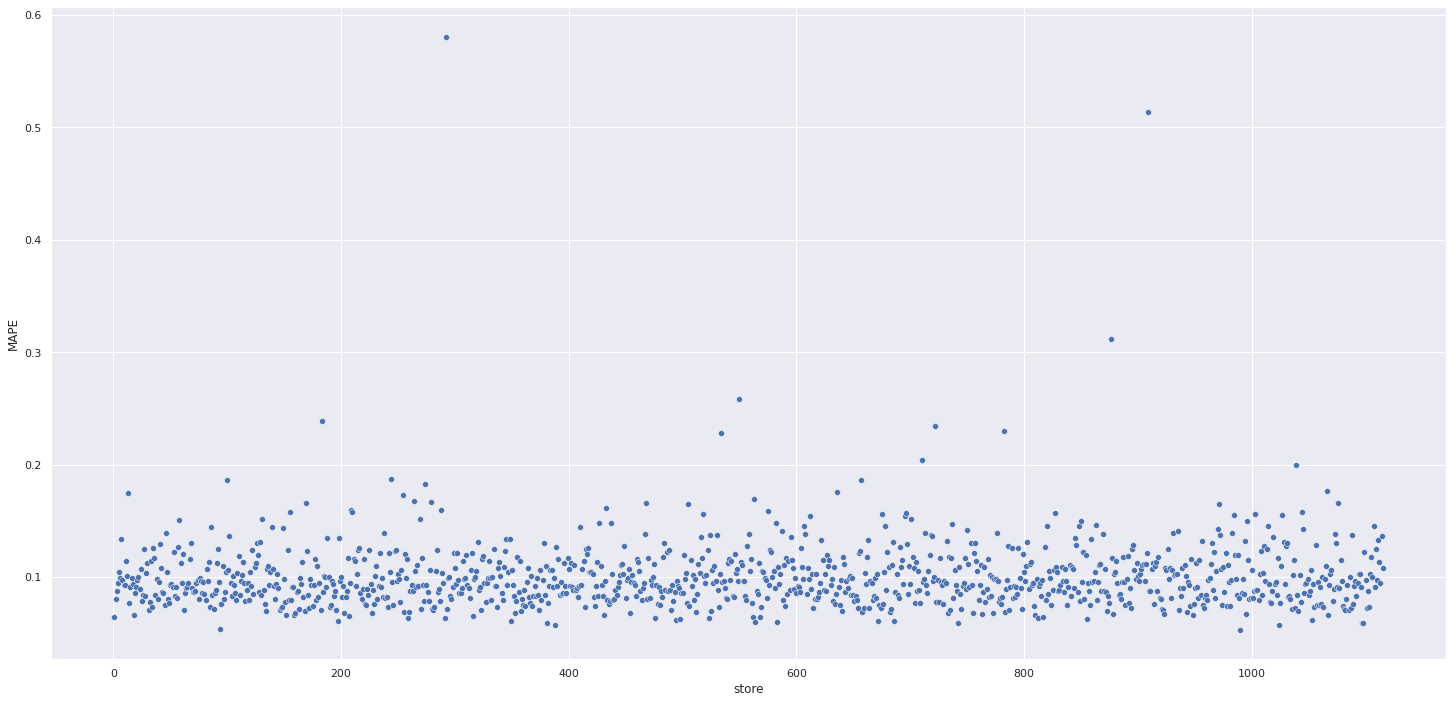

In [ ]:
# scatterplot of challenging stores
sns.scatterplot(x = 'store', y = 'MAPE', data = df_all);

## 9.2. Total Performance (Total sales revenue for the next 6 weeks)

In [ ]:
df_performance = df_all[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), 
                                                               axis = 0).reset_index().rename(columns = 
                                                                {'index':'Scenario', 0:'Total Sales Revenues (6w)'})
df_performance['Total Sales Revenues (6w)'] = df_performance['Total Sales Revenues (6w)'].map('R$ {:,.2f}'.format)
df_performance

,Scenario,Total Sales Revenues (6w)
0,predictions,"R$ 285,185,760.00"
1,worst_scenario,"R$ 284,417,658.93"
2,best_scenario,"R$ 285,953,893.40"


## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

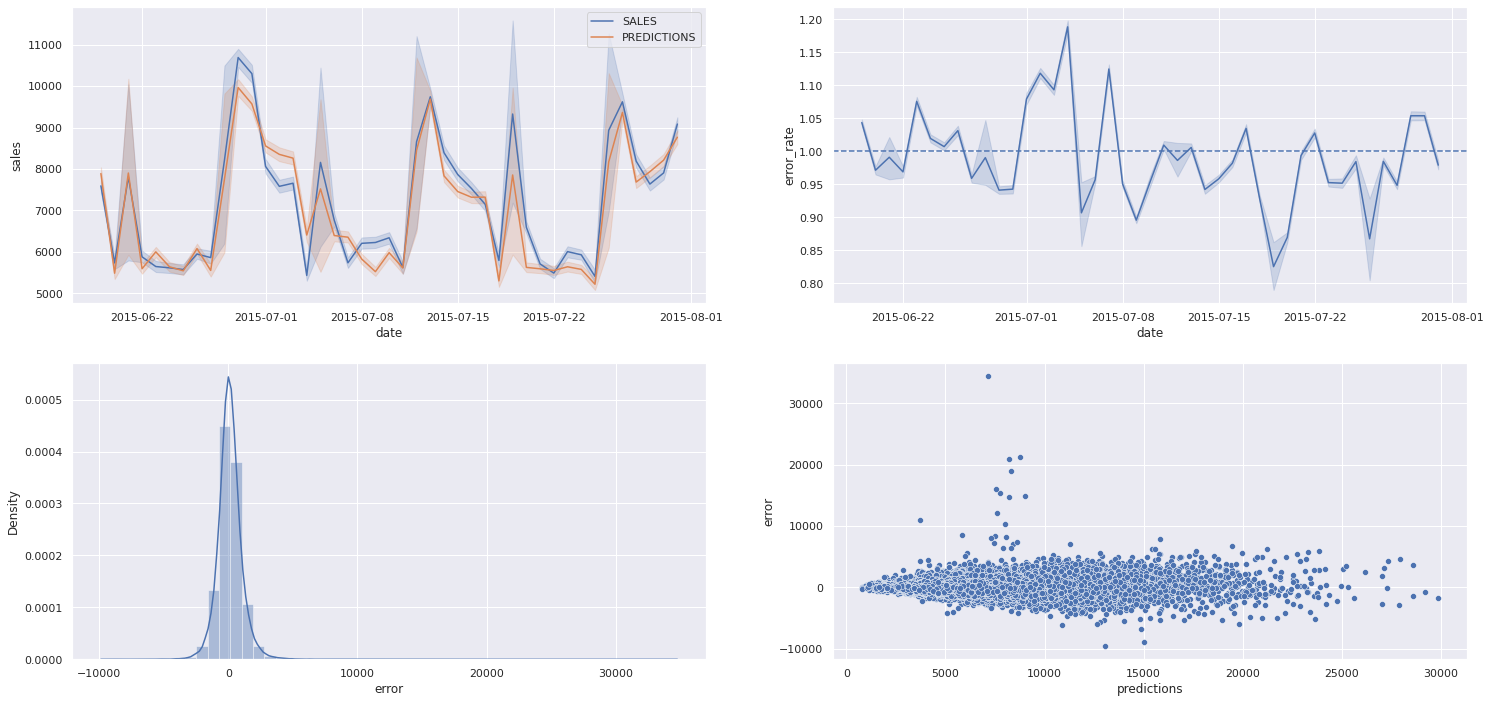

In [ ]:
# line plot with sales and its predicted values
plt.subplot(221)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES');
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS');

# error rate (predictions / sales)
plt.subplot(222)
sns.lineplot(x = 'date', y = 'error_rate', data = df9);
plt.axhline(1, linestyle = '--')

# error distribution (residual check)
plt.subplot(223)
sns.distplot(df9['error']);

# predictions vs error (residual check)
plt.subplot(224) 
sns.scatterplot(x = 'predictions', y = 'error', data = df9);